# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/22/20


3/22/20
Country/Region                 
China                     81397
Italy                     59138
US                        33272
Spain                     28768
Germany                   24873
Iran                      21638
France                    16176
Korea, South               8897
Switzerland                7245
United Kingdom             5741
Netherlands                4216
Belgium                    3401
Austria                    3244
Norway                     2383
Sweden                     1934
Portugal                   1600
Brazil                     1593
Denmark                    1514
Canada                     1465
Australia                  1314
Malaysia                   1306
Turkey                     1236
Czechia                    1120
Japan                      1086
Israel                     1071
Ireland                     906
Luxembourg                  798
Ecuador                     789
Pakistan                    776
Cruise Ship                 712
...                         ...
Estonia                     326
South Africa                274
Croatia                     254
Mexico                      251
Lebanon                     248
Panama                      245
Iraq                        233
Colombia                    231
Argentina                   225
Serbia                      222
Dominican Republic          202
Algeria                     201
Armenia                     194
Kuwait                      188
Bulgaria                    187
Slovakia                    185
Taiwan*                     169
San Marino                  160
United Arab Emirates        153
Latvia                      139
Uruguay                     135
Costa Rica                  134
Lithuania                   131
Hungary                     131
Bosnia and Herzegovina      126
Morocco                     115
North Macedonia             114
Andorra                     113
Vietnam                     113
Jordan                      112

[78 rows x 1 columns]

## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 81397
	Confirmed cases on 3/15/20 	 81003
	Ratio: 1.0
	Weekly increase: 0.5 %
	Daily increase: 0.1 % per day
	Doubling Time (represents recent growth): 1000.0 days

** Based on Logistic Fit**

	R^2: 0.995468983481
	Doubling Time (during middle of growth):  6.47 (± 0.52 ) days


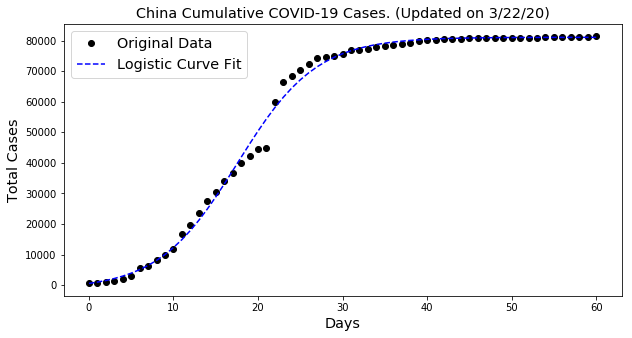



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 59138
	Confirmed cases on 3/15/20 	 24747
	Ratio: 2.39
	Weekly increase: 139.0 %
	Daily increase: 13.3 % per day
	Doubling Time (represents recent growth): 5.6 days

** Based on Logistic Fit**

	R^2: 0.999096722197
	Doubling Time (during middle of growth):  7.26 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.995394441887
	Doubling Time (represents overall growth):  4.77 (± 0.2 ) days


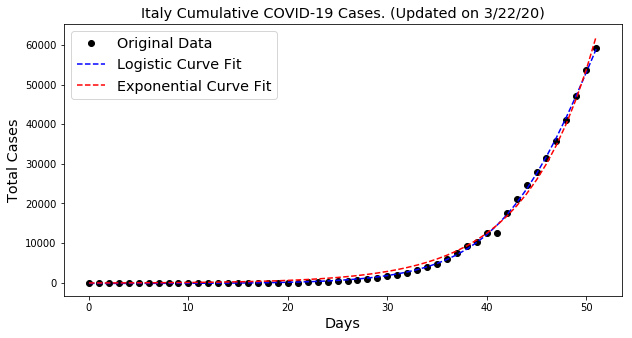



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 33272
	Confirmed cases on 3/15/20 	 3499
	Ratio: 9.51
	Weekly increase: 850.9 %
	Daily increase: 38.0 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Exponential Fit **

	R^2: 0.997091740529
	Doubling Time (represents overall growth):  2.17 (± 0.06 ) days


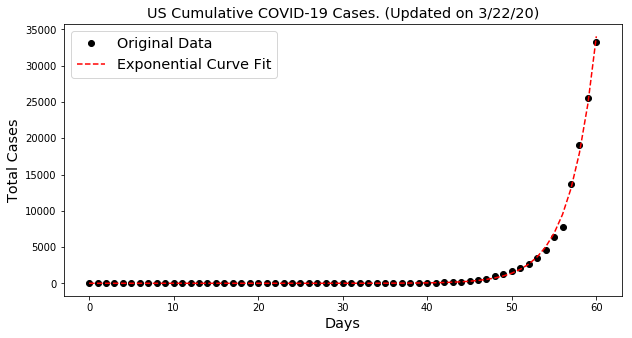



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 28768
	Confirmed cases on 3/15/20 	 7798
	Ratio: 3.69
	Weekly increase: 268.9 %
	Daily increase: 20.5 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.997831004669
	Doubling Time (during middle of growth):  4.86 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.992925072056
	Doubling Time (represents overall growth):  3.45 (± 0.17 ) days


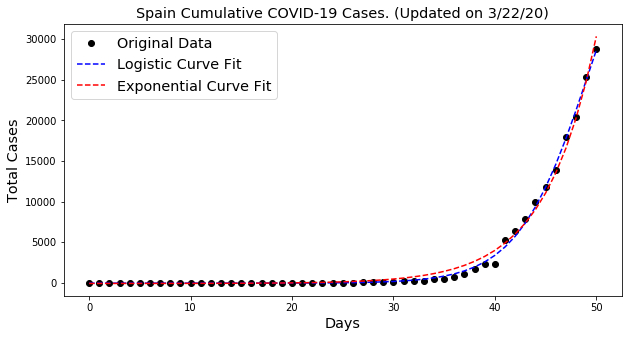



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 24873
	Confirmed cases on 3/15/20 	 5795
	Ratio: 4.29
	Weekly increase: 329.2 %
	Daily increase: 23.1 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.992024455855
	Doubling Time (represents overall growth):  3.31 (± 0.16 ) days


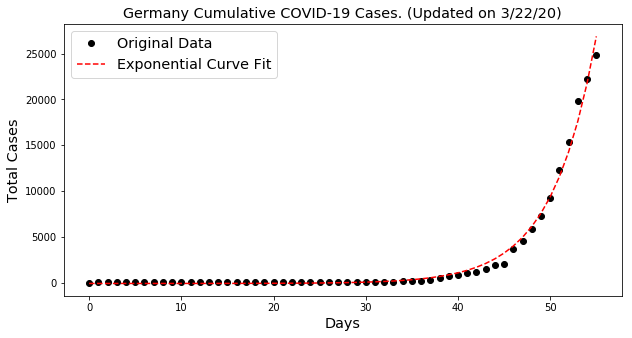



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 21638
	Confirmed cases on 3/15/20 	 13938
	Ratio: 1.55
	Weekly increase: 55.2 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.998092305638
	Doubling Time (during middle of growth):  7.73 (± 0.74 ) days


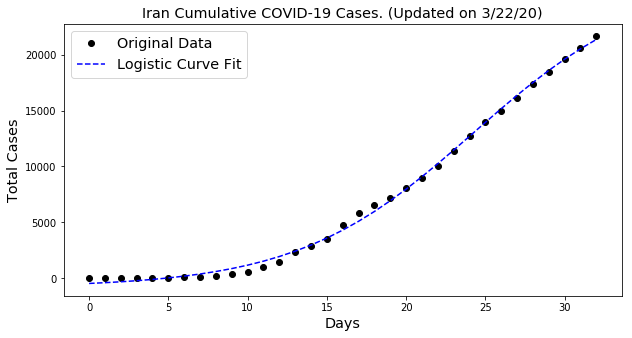



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 16176
	Confirmed cases on 3/15/20 	 4523
	Ratio: 3.58
	Weekly increase: 257.6 %
	Daily increase: 20.0 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Exponential Fit **

	R^2: 0.993660975576
	Doubling Time (represents overall growth):  4.01 (± 0.17 ) days


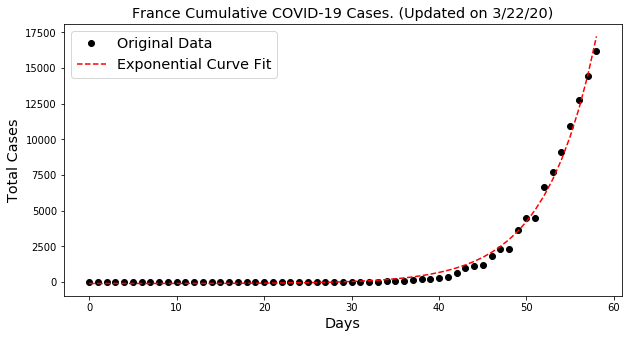



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 8897
	Confirmed cases on 3/15/20 	 8162
	Ratio: 1.09
	Weekly increase: 9.0 %
	Daily increase: 1.2 % per day
	Doubling Time (represents recent growth): 56.3 days


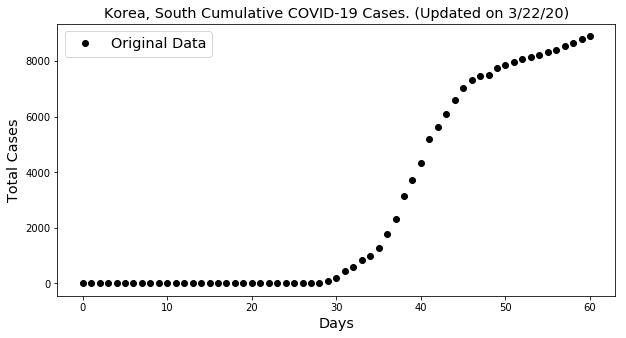



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 7245
	Confirmed cases on 3/15/20 	 2200
	Ratio: 3.29
	Weekly increase: 229.3 %
	Daily increase: 18.6 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.994678157158
	Doubling Time (during middle of growth):  5.55 (± 1.11 ) days

** Based on Exponential Fit **

	R^2: 0.993651340057
	Doubling Time (represents overall growth):  3.44 (± 0.26 ) days


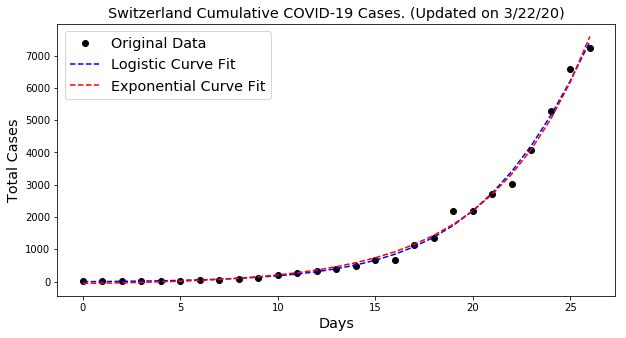



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 5741
	Confirmed cases on 3/15/20 	 1145
	Ratio: 5.01
	Weekly increase: 401.4 %
	Daily increase: 25.9 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Exponential Fit **

	R^2: 0.995140444781
	Doubling Time (represents overall growth):  3.11 (± 0.13 ) days


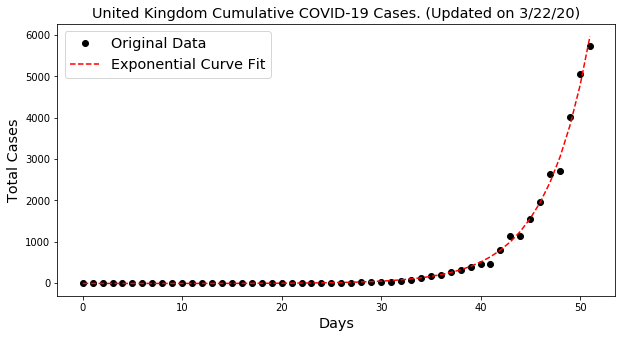



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 4216
	Confirmed cases on 3/15/20 	 1138
	Ratio: 3.7
	Weekly increase: 270.5 %
	Daily increase: 20.6 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.999321996958
	Doubling Time (during middle of growth):  6.65 (± 0.59 ) days

** Based on Exponential Fit **

	R^2: 0.998965266112
	Doubling Time (represents overall growth):  3.85 (± 0.13 ) days


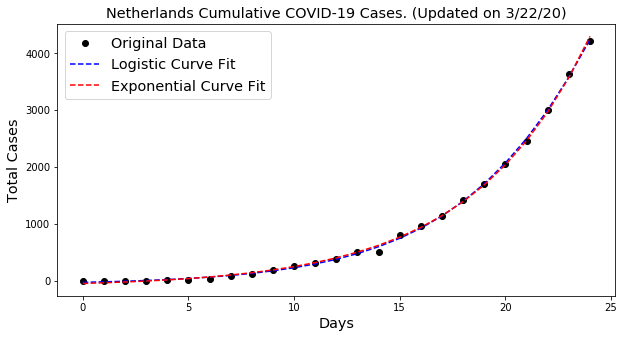



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 3401
	Confirmed cases on 3/15/20 	 886
	Ratio: 3.84
	Weekly increase: 283.9 %
	Daily increase: 21.2 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.998376099438
	Doubling Time (represents overall growth):  3.4 (± 0.08 ) days


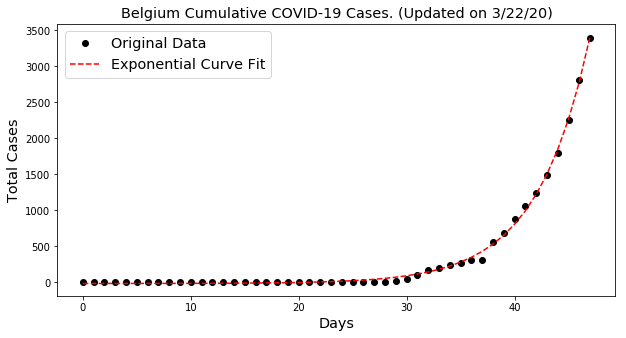



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 3244
	Confirmed cases on 3/15/20 	 860
	Ratio: 3.77
	Weekly increase: 277.2 %
	Daily increase: 20.9 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.999574487357
	Doubling Time (during middle of growth):  4.64 (± 0.23 ) days

** Based on Exponential Fit **

	R^2: 0.994552187029
	Doubling Time (represents overall growth):  3.67 (± 0.26 ) days


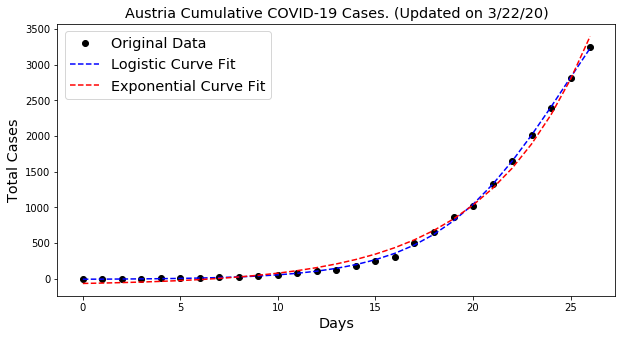



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 2383
	Confirmed cases on 3/15/20 	 1221
	Ratio: 1.95
	Weekly increase: 95.2 %
	Daily increase: 10.0 % per day
	Doubling Time (represents recent growth): 7.3 days

** Based on Logistic Fit**

	R^2: 0.990706418718
	Doubling Time (during middle of growth):  5.63 (± 1.31 ) days

** Based on Exponential Fit **

	R^2: 0.967936160608
	Doubling Time (represents overall growth):  5.27 (± 1.15 ) days


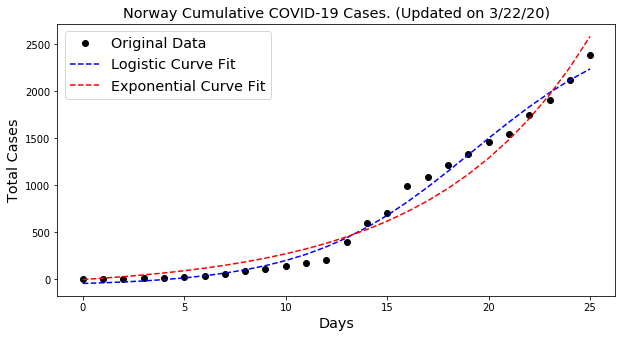



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1934
	Confirmed cases on 3/15/20 	 1022
	Ratio: 1.89
	Weekly increase: 89.2 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.994072719975
	Doubling Time (during middle of growth):  5.28 (± 0.57 ) days

** Based on Exponential Fit **

	R^2: 0.976031584785
	Doubling Time (represents overall growth):  5.53 (± 0.53 ) days


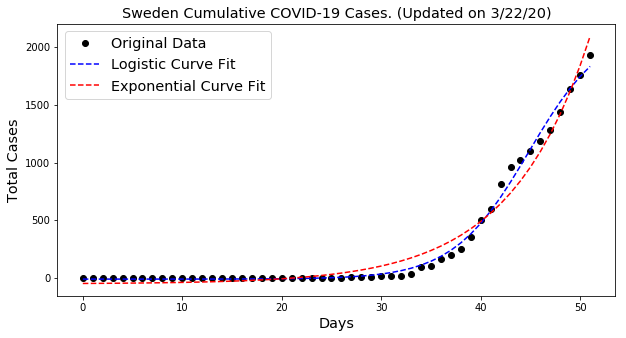



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1600
	Confirmed cases on 3/15/20 	 245
	Ratio: 6.53
	Weekly increase: 553.1 %
	Daily increase: 30.7 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.995780457232
	Doubling Time (during middle of growth):  4.03 (± 0.81 ) days

** Based on Exponential Fit **

	R^2: 0.994323238124
	Doubling Time (represents overall growth):  2.63 (± 0.21 ) days


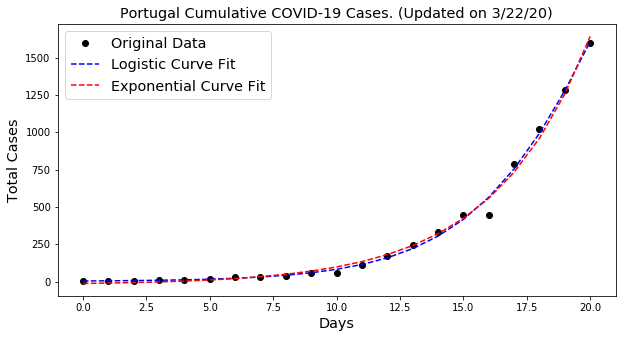



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1593
	Confirmed cases on 3/15/20 	 162
	Ratio: 9.83
	Weekly increase: 883.3 %
	Daily increase: 38.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Exponential Fit **

	R^2: 0.994293894228
	Doubling Time (represents overall growth):  2.08 (± 0.14 ) days


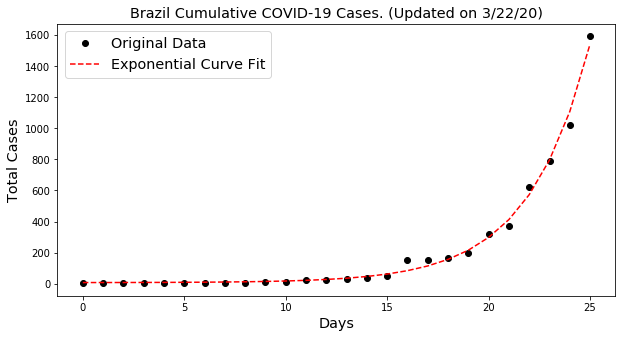



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1514
	Confirmed cases on 3/15/20 	 875
	Ratio: 1.73
	Weekly increase: 73.0 %
	Daily increase: 8.1 % per day
	Doubling Time (represents recent growth): 8.8 days

** Based on Logistic Fit**

	R^2: 0.98214224311
	Doubling Time (during middle of growth):  4.1 (± 1.14 ) days


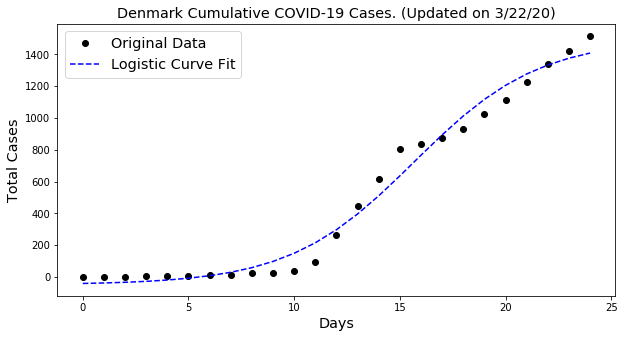



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1465
	Confirmed cases on 3/15/20 	 252
	Ratio: 5.81
	Weekly increase: 481.3 %
	Daily increase: 28.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.99610742434
	Doubling Time (represents overall growth):  3.0 (± 0.1 ) days


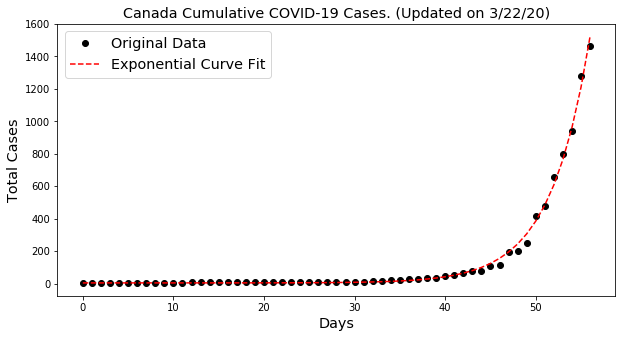



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1314
	Confirmed cases on 3/15/20 	 297
	Ratio: 4.42
	Weekly increase: 342.4 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Exponential Fit **

	R^2: 0.99843622694
	Doubling Time (represents overall growth):  3.17 (± 0.07 ) days


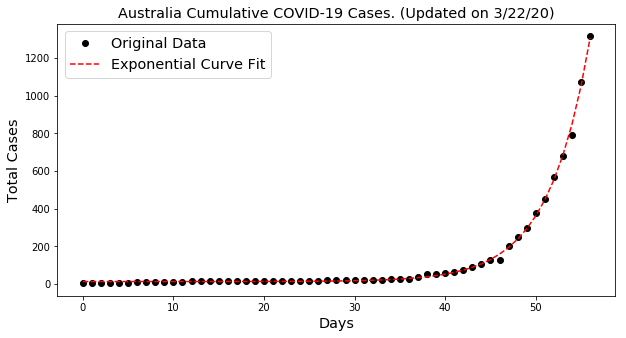



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1306
	Confirmed cases on 3/15/20 	 428
	Ratio: 3.05
	Weekly increase: 205.1 %
	Daily increase: 17.3 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.985333051443
	Doubling Time (represents overall growth):  3.88 (± 0.26 ) days


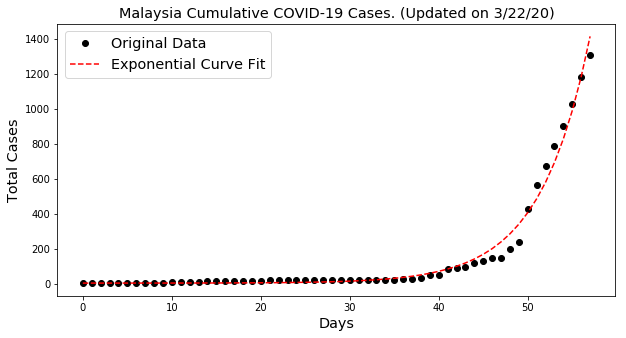



Turkey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1236
	Confirmed cases on 3/15/20 	 6
	Ratio: 206.0
	Weekly increase: 20500.0 %
	Daily increase: 114.1 % per day
	Doubling Time (represents recent growth): 0.9 days

** Based on Logistic Fit**

	R^2: 0.999916719622
	Doubling Time (during middle of growth):  2.14 (± 0.11 ) days

** Based on Exponential Fit **

	R^2: 0.999868679887
	Doubling Time (represents overall growth):  1.13 (± 0.02 ) days


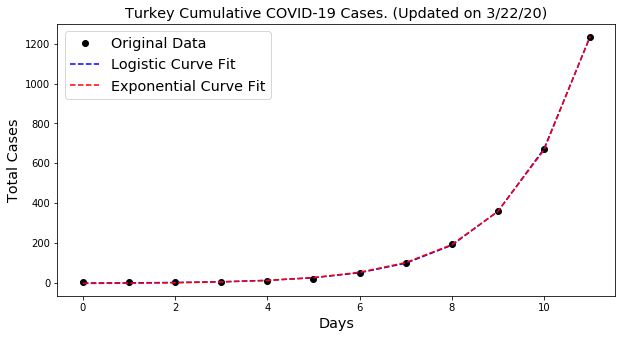



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1120
	Confirmed cases on 3/15/20 	 253
	Ratio: 4.43
	Weekly increase: 342.7 %
	Daily increase: 23.7 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.99705424107
	Doubling Time (during middle of growth):  4.14 (± 0.62 ) days

** Based on Exponential Fit **

	R^2: 0.99226341019
	Doubling Time (represents overall growth):  3.37 (± 0.33 ) days


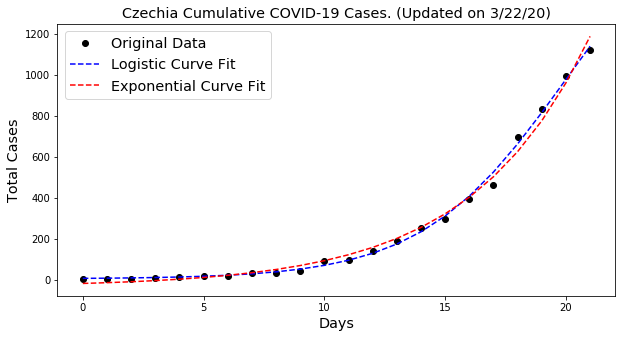



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1086
	Confirmed cases on 3/15/20 	 839
	Ratio: 1.29
	Weekly increase: 29.4 %
	Daily increase: 3.8 % per day
	Doubling Time (represents recent growth): 18.8 days

** Based on Logistic Fit**

	R^2: 0.997908273539
	Doubling Time (during middle of growth):  11.34 (± 0.75 ) days

** Based on Exponential Fit **

	R^2: 0.988209031884
	Doubling Time (represents overall growth):  11.7 (± 0.91 ) days


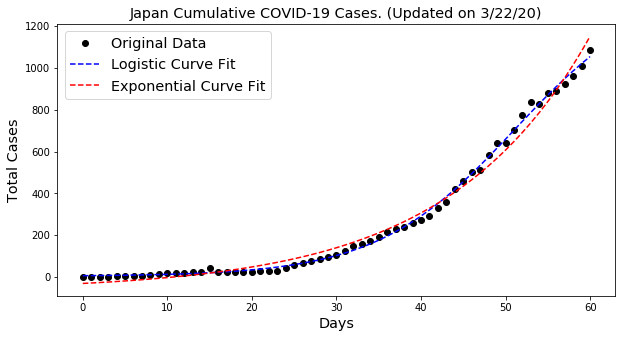



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1071
	Confirmed cases on 3/15/20 	 251
	Ratio: 4.27
	Weekly increase: 326.7 %
	Daily increase: 23.0 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.993785240802
	Doubling Time (during middle of growth):  5.75 (± 1.14 ) days

** Based on Exponential Fit **

	R^2: 0.993459423548
	Doubling Time (represents overall growth):  3.26 (± 0.22 ) days


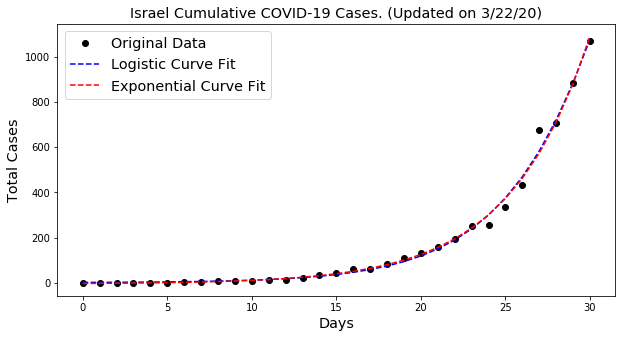



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 906
	Confirmed cases on 3/15/20 	 129
	Ratio: 7.02
	Weekly increase: 602.3 %
	Daily increase: 32.1 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.990283255585
	Doubling Time (during middle of growth):  2.74 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.979089462297
	Doubling Time (represents overall growth):  2.81 (± 0.42 ) days


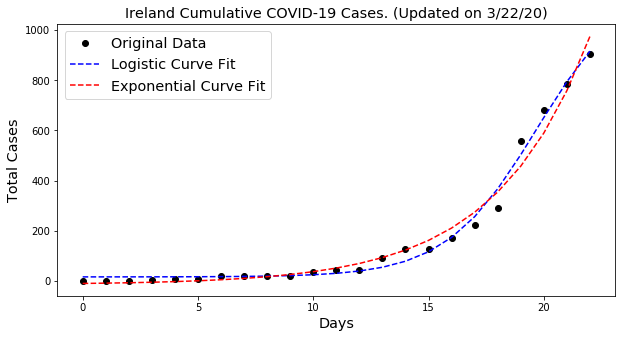



Luxembourg

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 798
	Confirmed cases on 3/15/20 	 59
	Ratio: 13.53
	Weekly increase: 1252.5 %
	Daily increase: 45.1 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.989766348515
	Doubling Time (represents overall growth):  2.16 (± 0.21 ) days


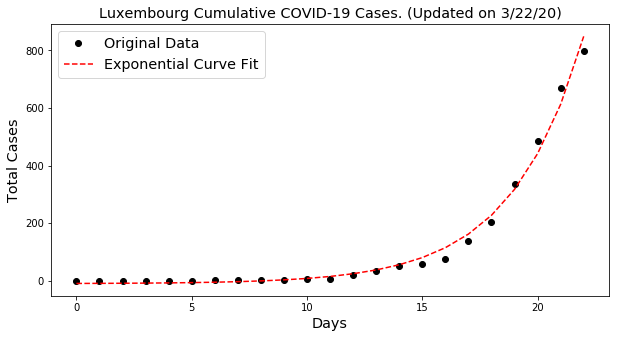



Ecuador

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 789
	Confirmed cases on 3/15/20 	 28
	Ratio: 28.18
	Weekly increase: 2717.9 %
	Daily increase: 61.1 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Exponential Fit **

	R^2: 0.995067476854
	Doubling Time (represents overall growth):  1.49 (± 0.1 ) days


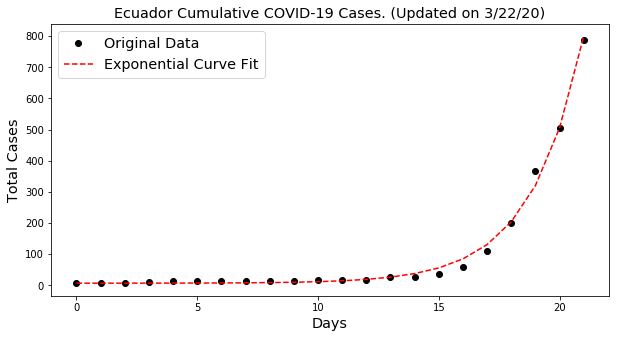



Pakistan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 776
	Confirmed cases on 3/15/20 	 53
	Ratio: 14.64
	Weekly increase: 1364.2 %
	Daily increase: 46.7 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.993384887768
	Doubling Time (during middle of growth):  2.54 (± 0.44 ) days

** Based on Exponential Fit **

	R^2: 0.976151678078
	Doubling Time (represents overall growth):  2.61 (± 0.37 ) days


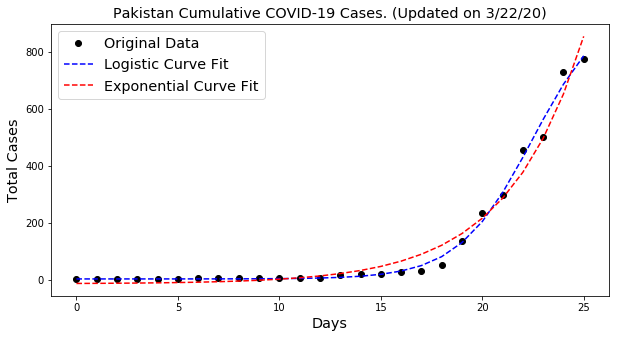



Cruise Ship

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 712
	Confirmed cases on 3/15/20 	 696
	Ratio: 1.02
	Weekly increase: 2.3 %
	Daily increase: 0.3 % per day
	Doubling Time (represents recent growth): 213.5 days

** Based on Logistic Fit**

	R^2: 0.995636830777
	Doubling Time (during middle of growth):  2.71 (± 0.27 ) days


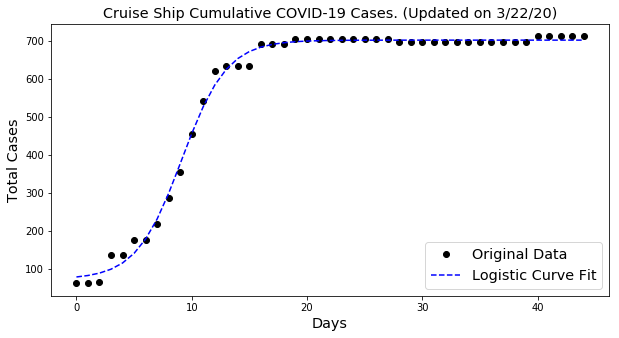



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 634
	Confirmed cases on 3/15/20 	 119
	Ratio: 5.33
	Weekly increase: 432.8 %
	Daily increase: 27.0 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.997669267279
	Doubling Time (during middle of growth):  4.96 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.996315566457
	Doubling Time (represents overall growth):  3.38 (± 0.27 ) days


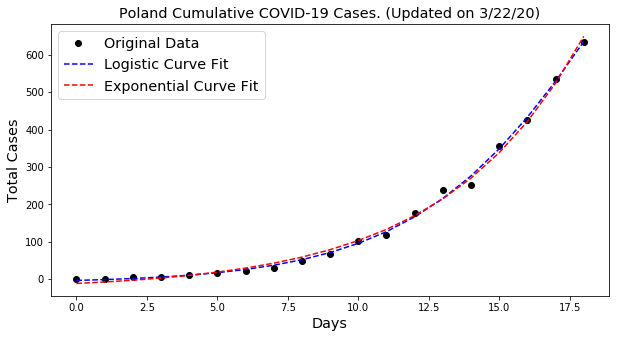



Chile

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 632
	Confirmed cases on 3/15/20 	 74
	Ratio: 8.54
	Weekly increase: 754.1 %
	Daily increase: 35.9 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.987600586488
	Doubling Time (during middle of growth):  4.02 (± 1.44 ) days

** Based on Exponential Fit **

	R^2: 0.985601012088
	Doubling Time (represents overall growth):  2.73 (± 0.38 ) days


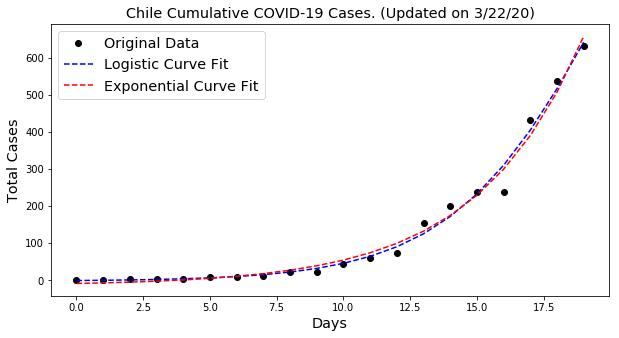



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 626
	Confirmed cases on 3/15/20 	 244
	Ratio: 2.57
	Weekly increase: 156.6 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.1 days

** Based on Exponential Fit **

	R^2: 0.979692625385
	Doubling Time (represents overall growth):  4.16 (± 0.34 ) days


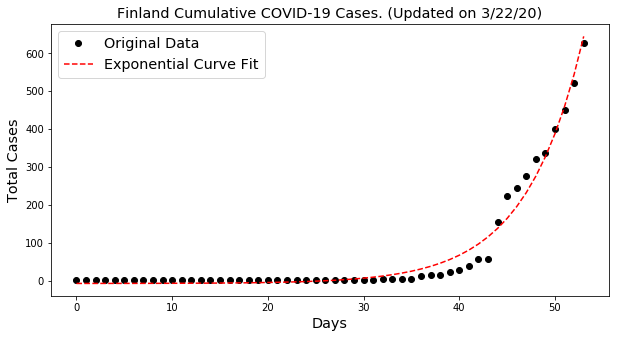



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 624
	Confirmed cases on 3/15/20 	 331
	Ratio: 1.89
	Weekly increase: 88.5 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.7 days

** Based on Logistic Fit**

	R^2: 0.987387810651
	Doubling Time (during middle of growth):  5.11 (± 1.33 ) days

** Based on Exponential Fit **

	R^2: 0.977021525675
	Doubling Time (represents overall growth):  6.27 (± 1.27 ) days


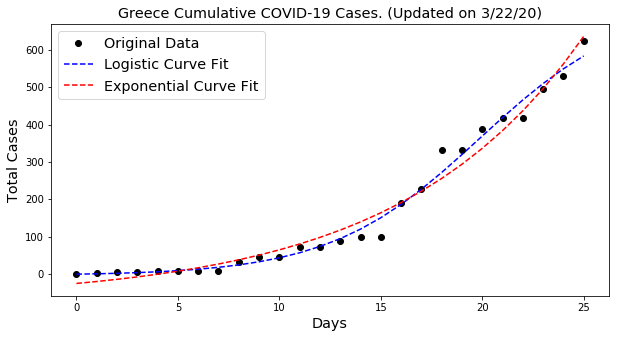



Thailand

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 599
	Confirmed cases on 3/15/20 	 114
	Ratio: 5.25
	Weekly increase: 425.4 %
	Daily increase: 26.7 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.985556957079
	Doubling Time (represents overall growth):  2.56 (± 0.16 ) days


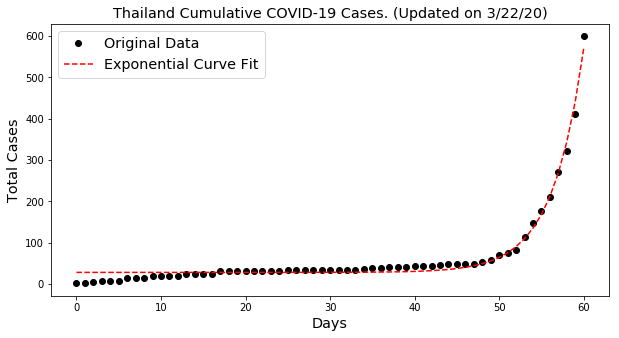



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 568
	Confirmed cases on 3/15/20 	 171
	Ratio: 3.32
	Weekly increase: 232.2 %
	Daily increase: 18.7 % per day
	Doubling Time (represents recent growth): 4.0 days

** Based on Logistic Fit**

	R^2: 0.994959092854
	Doubling Time (during middle of growth):  7.98 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.994959093058
	Doubling Time (represents overall growth):  3.99 (± 0.31 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


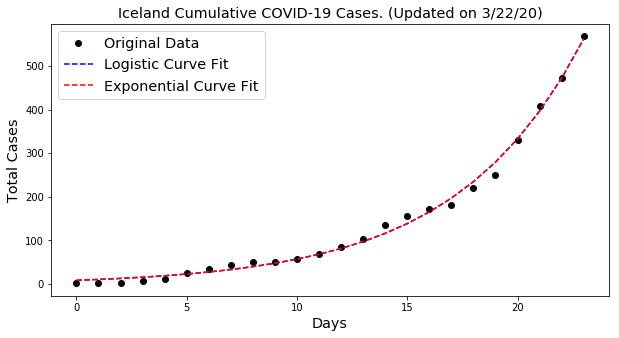



Indonesia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 514
	Confirmed cases on 3/15/20 	 117
	Ratio: 4.39
	Weekly increase: 339.3 %
	Daily increase: 23.5 % per day
	Doubling Time (represents recent growth): 3.3 days

** Based on Logistic Fit**

	R^2: 0.997696063123
	Doubling Time (during middle of growth):  4.45 (± 0.65 ) days

** Based on Exponential Fit **

	R^2: 0.994336870402
	Doubling Time (represents overall growth):  3.43 (± 0.31 ) days


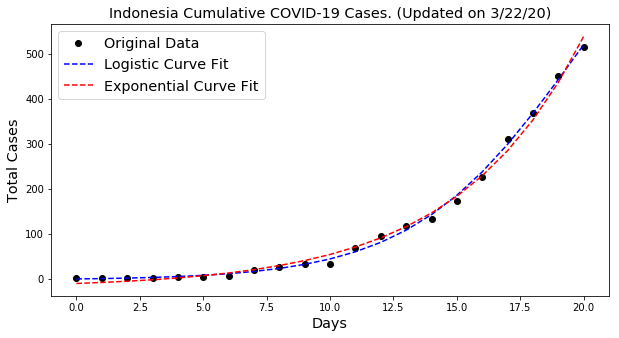



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 511
	Confirmed cases on 3/15/20 	 103
	Ratio: 4.96
	Weekly increase: 396.1 %
	Daily increase: 25.7 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.99148298402
	Doubling Time (during middle of growth):  6.36 (± 2.65 ) days

** Based on Exponential Fit **

	R^2: 0.991482984598
	Doubling Time (represents overall growth):  3.18 (± 0.34 ) days


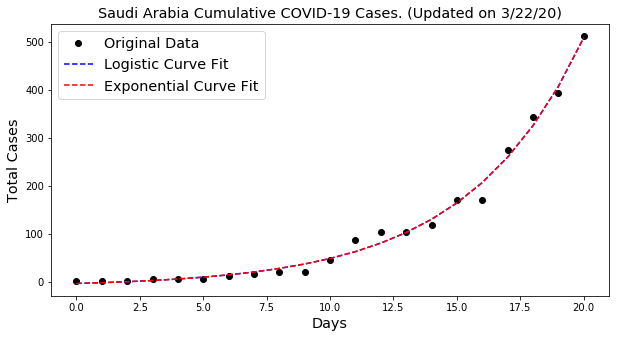



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 494
	Confirmed cases on 3/15/20 	 401
	Ratio: 1.23
	Weekly increase: 23.2 %
	Daily increase: 3.0 % per day
	Doubling Time (represents recent growth): 23.3 days

** Based on Logistic Fit**

	R^2: 0.97843300604
	Doubling Time (during middle of growth):  2.03 (± 0.64 ) days


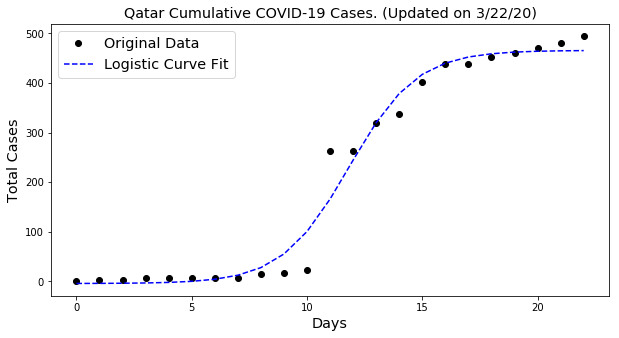



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 455
	Confirmed cases on 3/15/20 	 226
	Ratio: 2.01
	Weekly increase: 101.3 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Logistic Fit**

	R^2: 0.968401356453
	Doubling Time (during middle of growth):  16.99 (± 2.14 ) days

** Based on Exponential Fit **

	R^2: 0.968401356962
	Doubling Time (represents overall growth):  8.5 (± 0.96 ) days


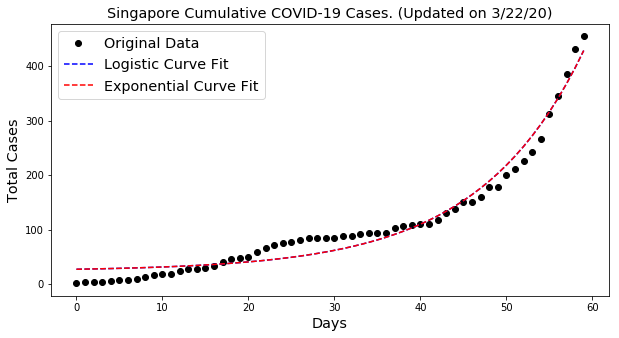



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 433
	Confirmed cases on 3/15/20 	 131
	Ratio: 3.31
	Weekly increase: 230.5 %
	Daily increase: 18.6 % per day
	Doubling Time (represents recent growth): 4.1 days

** Based on Logistic Fit**

	R^2: 0.994305971211
	Doubling Time (during middle of growth):  5.1 (± 0.96 ) days

** Based on Exponential Fit **

	R^2: 0.989068111004
	Doubling Time (represents overall growth):  4.23 (± 0.47 ) days


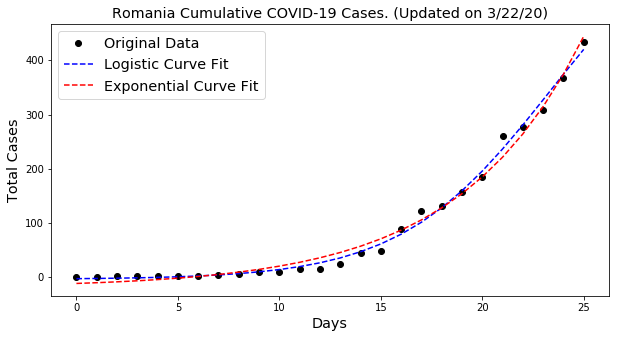



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 414
	Confirmed cases on 3/15/20 	 219
	Ratio: 1.89
	Weekly increase: 89.0 %
	Daily increase: 9.5 % per day
	Doubling Time (represents recent growth): 7.6 days

** Based on Logistic Fit**

	R^2: 0.983216977476
	Doubling Time (during middle of growth):  4.69 (± 2.06 ) days

** Based on Exponential Fit **

	R^2: 0.96022661736
	Doubling Time (represents overall growth):  6.94 (± 3.39 ) days


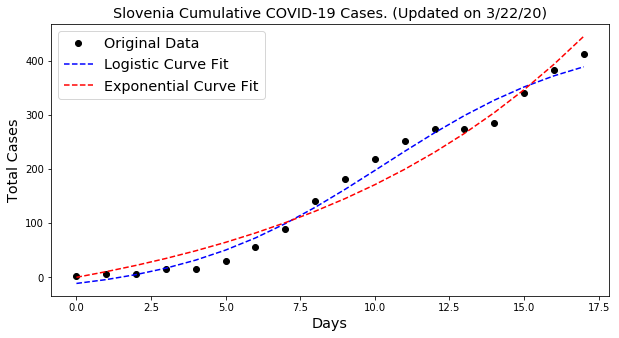



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 396
	Confirmed cases on 3/15/20 	 113
	Ratio: 3.5
	Weekly increase: 250.4 %
	Daily increase: 19.6 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Exponential Fit **

	R^2: 0.989609483583
	Doubling Time (represents overall growth):  3.72 (± 0.22 ) days


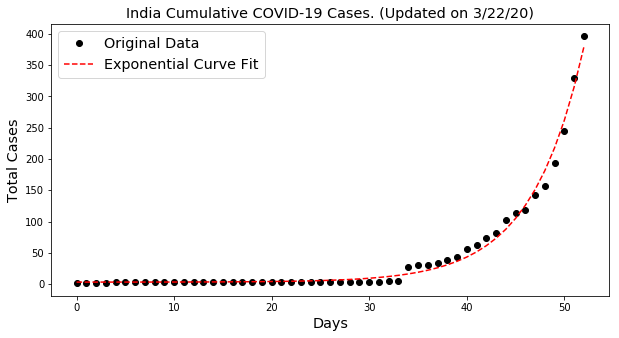



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 380
	Confirmed cases on 3/15/20 	 140
	Ratio: 2.71
	Weekly increase: 171.4 %
	Daily increase: 15.3 % per day
	Doubling Time (represents recent growth): 4.9 days

** Based on Exponential Fit **

	R^2: 0.982582588842
	Doubling Time (represents overall growth):  3.93 (± 0.3 ) days


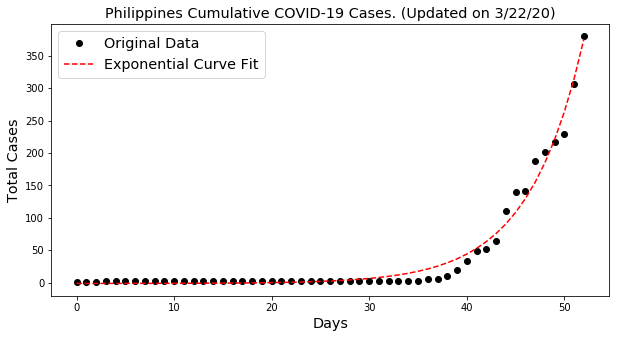



Russia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 367
	Confirmed cases on 3/15/20 	 63
	Ratio: 5.83
	Weekly increase: 482.5 %
	Daily increase: 28.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.997020382189
	Doubling Time (represents overall growth):  2.92 (± 0.09 ) days


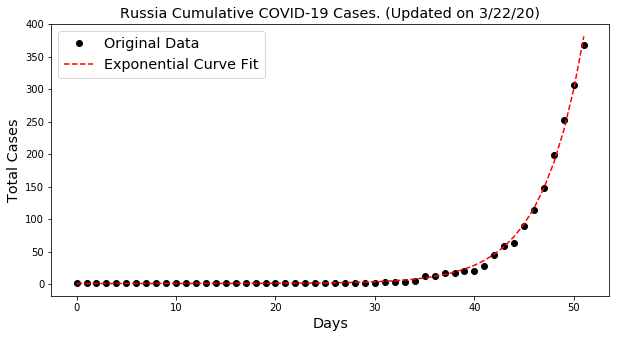



Peru

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 363
	Confirmed cases on 3/15/20 	 43
	Ratio: 8.44
	Weekly increase: 744.2 %
	Daily increase: 35.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.991921960012
	Doubling Time (during middle of growth):  3.21 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.983425662885
	Doubling Time (represents overall growth):  3.23 (± 0.61 ) days


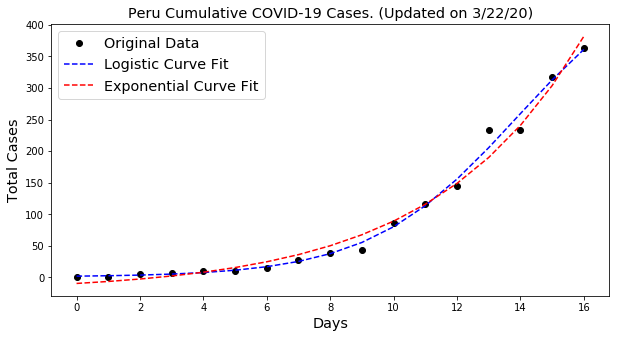



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 332
	Confirmed cases on 3/15/20 	 214
	Ratio: 1.55
	Weekly increase: 55.1 %
	Daily increase: 6.5 % per day
	Doubling Time (represents recent growth): 11.0 days

** Based on Logistic Fit**

	R^2: 0.974823781216
	Doubling Time (during middle of growth):  6.98 (± 2.8 ) days

** Based on Exponential Fit **

	R^2: 0.966560842572
	Doubling Time (represents overall growth):  12.77 (± 5.02 ) days


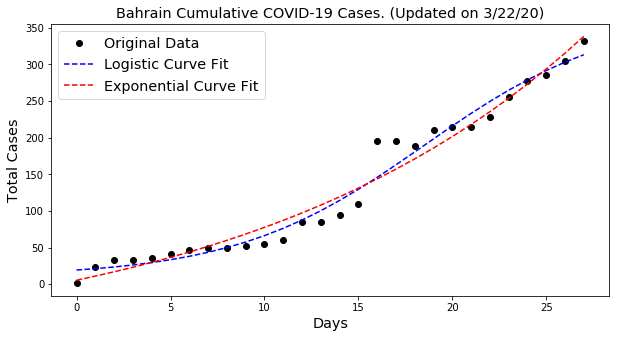



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 327
	Confirmed cases on 3/15/20 	 110
	Ratio: 2.97
	Weekly increase: 197.3 %
	Daily increase: 16.8 % per day
	Doubling Time (represents recent growth): 4.5 days

** Based on Logistic Fit**

	R^2: 0.992273913434
	Doubling Time (during middle of growth):  5.62 (± 0.9 ) days

** Based on Exponential Fit **

	R^2: 0.983913960107
	Doubling Time (represents overall growth):  4.82 (± 0.47 ) days


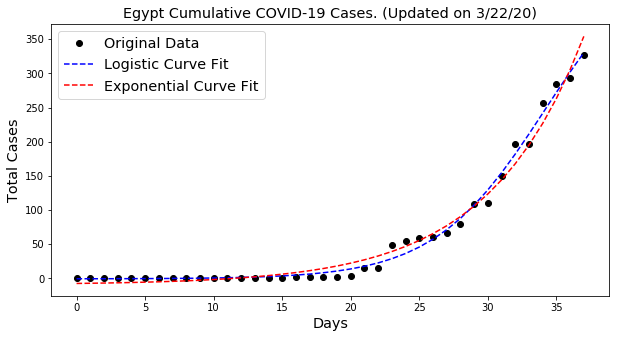



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 326
	Confirmed cases on 3/15/20 	 171
	Ratio: 1.91
	Weekly increase: 90.6 %
	Daily increase: 9.7 % per day
	Doubling Time (represents recent growth): 7.5 days

** Based on Logistic Fit**

	R^2: 0.99265240231
	Doubling Time (during middle of growth):  2.32 (± 0.4 ) days


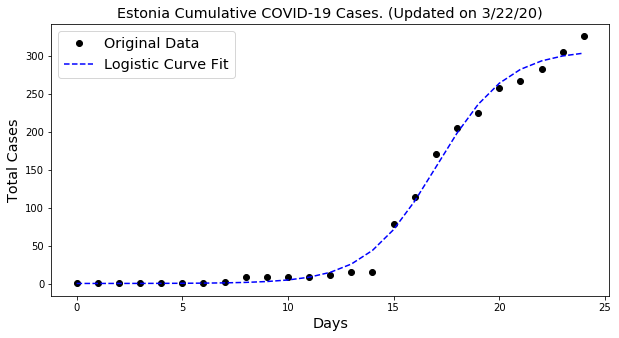



South Africa

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 274
	Confirmed cases on 3/15/20 	 51
	Ratio: 5.37
	Weekly increase: 437.3 %
	Daily increase: 27.1 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.994112154387
	Doubling Time (during middle of growth):  3.38 (± 0.79 ) days

** Based on Exponential Fit **

	R^2: 0.987843202508
	Doubling Time (represents overall growth):  3.09 (± 0.46 ) days


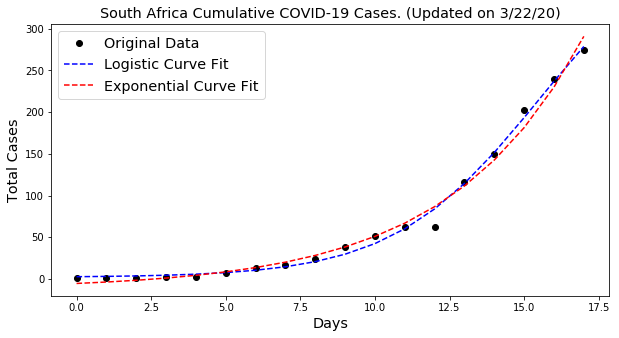



Croatia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 254
	Confirmed cases on 3/15/20 	 49
	Ratio: 5.18
	Weekly increase: 418.4 %
	Daily increase: 26.5 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Exponential Fit **

	R^2: 0.991686823457
	Doubling Time (represents overall growth):  2.42 (± 0.19 ) days


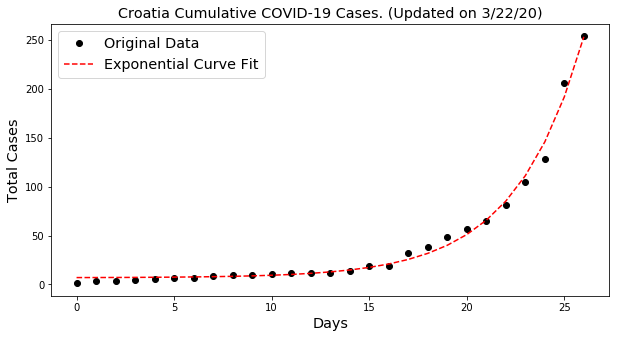



Mexico

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 251
	Confirmed cases on 3/15/20 	 41
	Ratio: 6.12
	Weekly increase: 512.2 %
	Daily increase: 29.5 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.997082644079
	Doubling Time (during middle of growth):  3.79 (± 0.53 ) days

** Based on Exponential Fit **

	R^2: 0.993810067685
	Doubling Time (represents overall growth):  2.68 (± 0.2 ) days


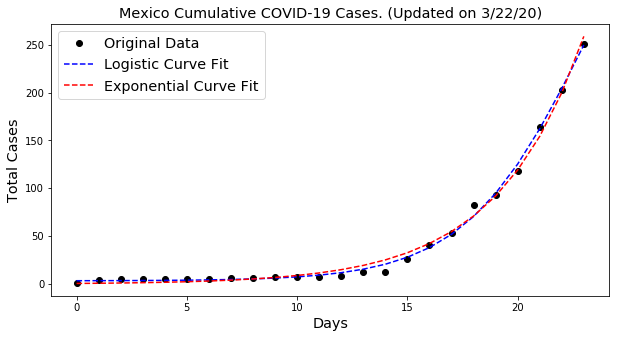



Lebanon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 248
	Confirmed cases on 3/15/20 	 110
	Ratio: 2.25
	Weekly increase: 125.5 %
	Daily increase: 12.3 % per day
	Doubling Time (represents recent growth): 6.0 days

** Based on Logistic Fit**

	R^2: 0.987387580467
	Doubling Time (during middle of growth):  11.31 (± 5.41 ) days

** Based on Exponential Fit **

	R^2: 0.987387581159
	Doubling Time (represents overall growth):  5.66 (± 0.64 ) days


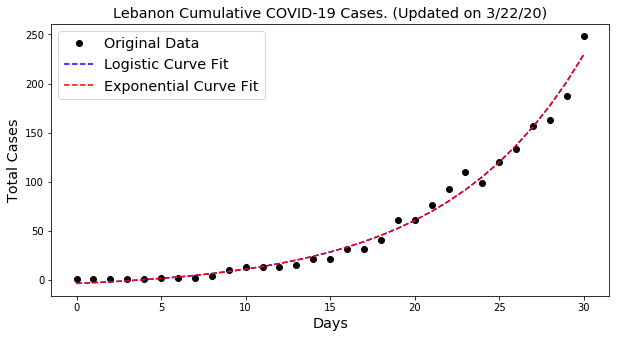



Panama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 245
	Confirmed cases on 3/15/20 	 43
	Ratio: 5.7
	Weekly increase: 469.8 %
	Daily increase: 28.2 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Logistic Fit**

	R^2: 0.994053180913
	Doubling Time (during middle of growth):  5.65 (± 1.52 ) days

** Based on Exponential Fit **

	R^2: 0.994053181386
	Doubling Time (represents overall growth):  2.82 (± 0.41 ) days


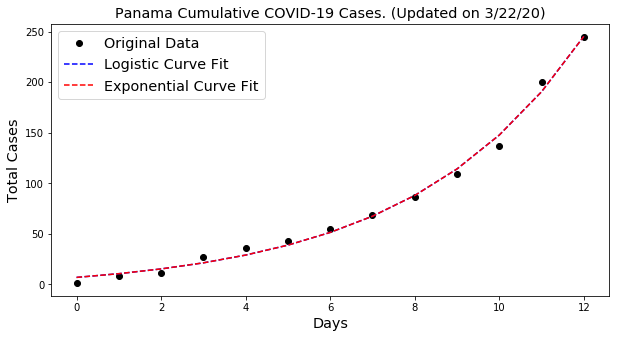



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 233
	Confirmed cases on 3/15/20 	 116
	Ratio: 2.01
	Weekly increase: 100.9 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 7.0 days

** Based on Logistic Fit**

	R^2: 0.993142969224
	Doubling Time (during middle of growth):  13.8 (± 7.22 ) days

** Based on Exponential Fit **

	R^2: 0.993061760536
	Doubling Time (represents overall growth):  8.1 (± 0.97 ) days


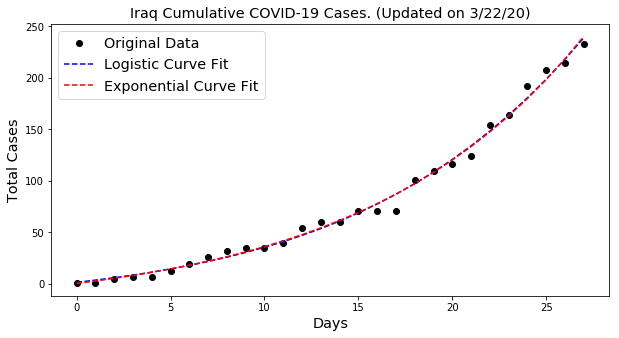



Colombia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 231
	Confirmed cases on 3/15/20 	 34
	Ratio: 6.79
	Weekly increase: 579.4 %
	Daily increase: 31.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.992187340355
	Doubling Time (during middle of growth):  5.04 (± 2.19 ) days

** Based on Exponential Fit **

	R^2: 0.992031912559
	Doubling Time (represents overall growth):  2.81 (± 0.34 ) days


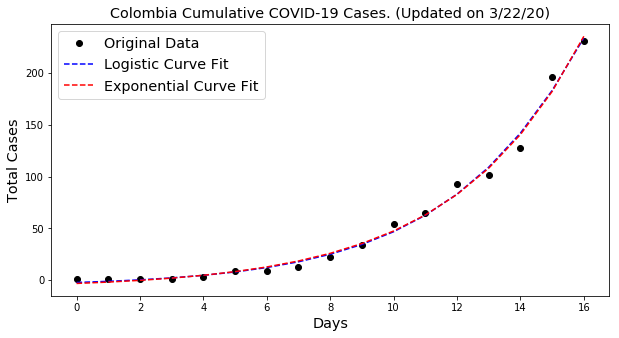



Argentina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 225
	Confirmed cases on 3/15/20 	 45
	Ratio: 5.0
	Weekly increase: 400.0 %
	Daily increase: 25.8 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.993124268465
	Doubling Time (during middle of growth):  5.63 (± 0.75 ) days

** Based on Exponential Fit **

	R^2: 0.99312426874
	Doubling Time (represents overall growth):  2.82 (± 0.27 ) days


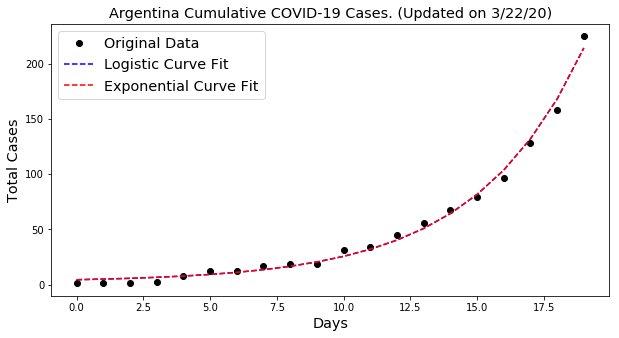



Serbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 222
	Confirmed cases on 3/15/20 	 48
	Ratio: 4.62
	Weekly increase: 362.5 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.992705194633
	Doubling Time (during middle of growth):  6.37 (± 1.42 ) days

** Based on Exponential Fit **

	R^2: 0.992705194828
	Doubling Time (represents overall growth):  3.19 (± 0.4 ) days


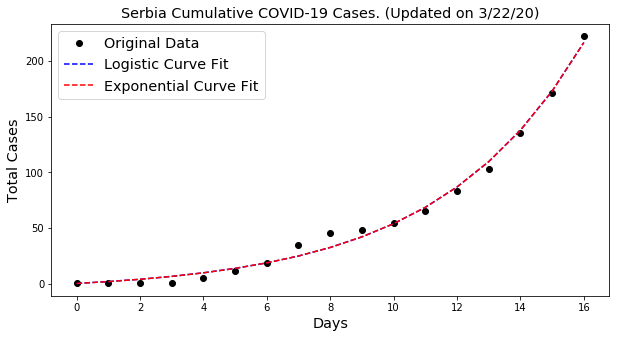



Dominican Republic

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 202
	Confirmed cases on 3/15/20 	 11
	Ratio: 18.36
	Weekly increase: 1736.4 %
	Daily increase: 51.6 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.995848038746
	Doubling Time (represents overall growth):  1.22 (± 0.08 ) days


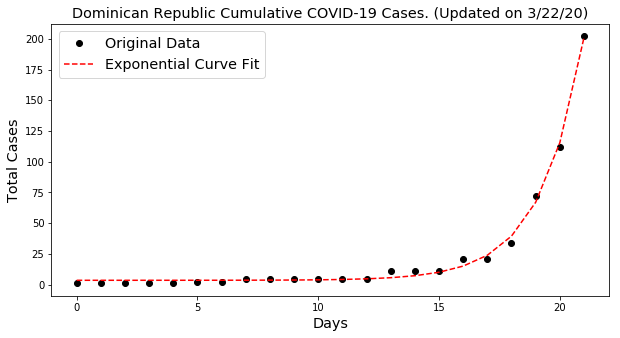



Algeria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 201
	Confirmed cases on 3/15/20 	 48
	Ratio: 4.19
	Weekly increase: 318.8 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.972164891921
	Doubling Time (during middle of growth):  5.71 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.972164893353
	Doubling Time (represents overall growth):  2.85 (± 0.43 ) days


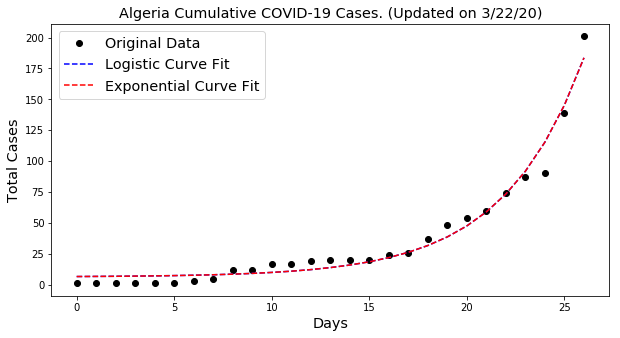



Armenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 194
	Confirmed cases on 3/15/20 	 26
	Ratio: 7.46
	Weekly increase: 646.2 %
	Daily increase: 33.3 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.993943760367
	Doubling Time (during middle of growth):  3.16 (± 0.59 ) days

** Based on Exponential Fit **

	R^2: 0.980698519719
	Doubling Time (represents overall growth):  3.16 (± 0.48 ) days


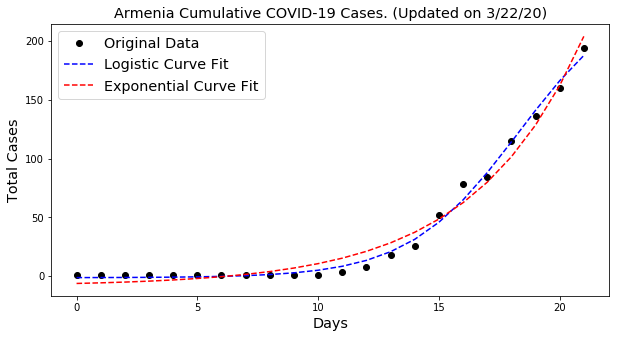



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 188
	Confirmed cases on 3/15/20 	 112
	Ratio: 1.68
	Weekly increase: 67.9 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.966340990414
	Doubling Time (during middle of growth):  17.65 (± 9.79 ) days

** Based on Exponential Fit **

	R^2: 0.96634099132
	Doubling Time (represents overall growth):  8.82 (± 2.54 ) days


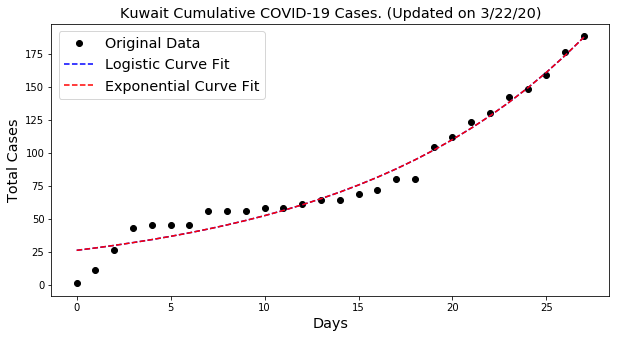



Bulgaria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 187
	Confirmed cases on 3/15/20 	 51
	Ratio: 3.67
	Weekly increase: 266.7 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Logistic Fit**

	R^2: 0.989468089857
	Doubling Time (during middle of growth):  7.79 (± 8.45 ) days

** Based on Exponential Fit **

	R^2: 0.989462928121
	Doubling Time (represents overall growth):  4.04 (± 0.83 ) days


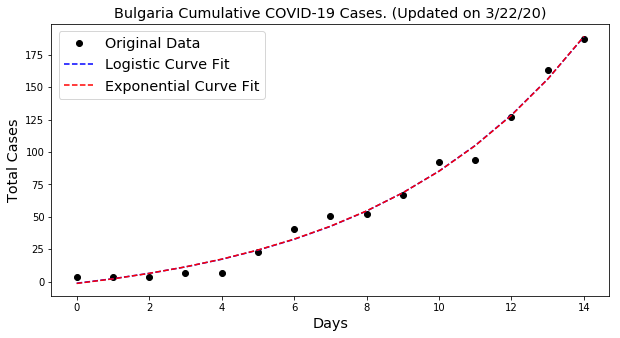



Slovakia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 185
	Confirmed cases on 3/15/20 	 54
	Ratio: 3.43
	Weekly increase: 242.6 %
	Daily increase: 19.2 % per day
	Doubling Time (represents recent growth): 3.9 days

** Based on Logistic Fit**

	R^2: 0.993360753441
	Doubling Time (during middle of growth):  4.84 (± 1.63 ) days

** Based on Exponential Fit **

	R^2: 0.98942740489
	Doubling Time (represents overall growth):  4.73 (± 0.92 ) days


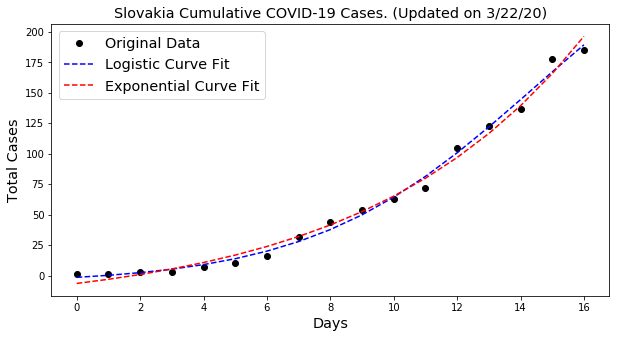



Taiwan*

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 169
	Confirmed cases on 3/15/20 	 59
	Ratio: 2.86
	Weekly increase: 186.4 %
	Daily increase: 16.2 % per day
	Doubling Time (represents recent growth): 4.6 days


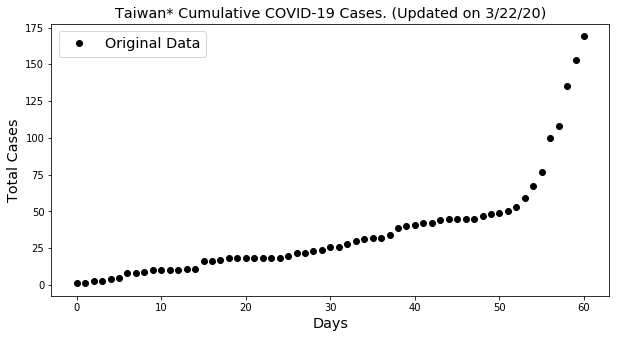



San Marino

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 160
	Confirmed cases on 3/15/20 	 101
	Ratio: 1.58
	Weekly increase: 58.4 %
	Daily increase: 6.8 % per day
	Doubling Time (represents recent growth): 10.5 days

** Based on Logistic Fit**

	R^2: 0.992352899603
	Doubling Time (during middle of growth):  7.77 (± 2.28 ) days

** Based on Exponential Fit **

	R^2: 0.987257984034
	Doubling Time (represents overall growth):  13.54 (± 4.06 ) days


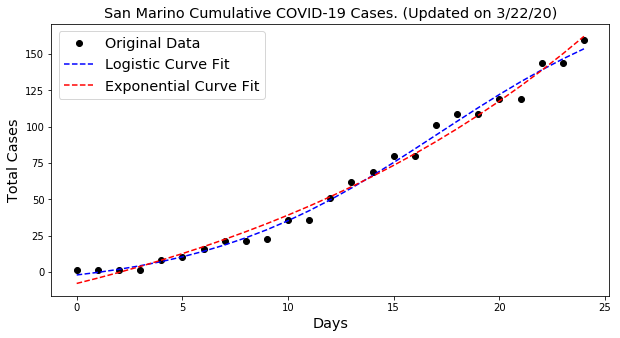



United Arab Emirates

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 153
	Confirmed cases on 3/15/20 	 98
	Ratio: 1.56
	Weekly increase: 56.1 %
	Daily increase: 6.6 % per day
	Doubling Time (represents recent growth): 10.9 days

** Based on Logistic Fit**

	R^2: 0.987941208618
	Doubling Time (during middle of growth):  9.0 (± 1.53 ) days

** Based on Exponential Fit **

	R^2: 0.981342030722
	Doubling Time (represents overall growth):  7.78 (± 0.71 ) days


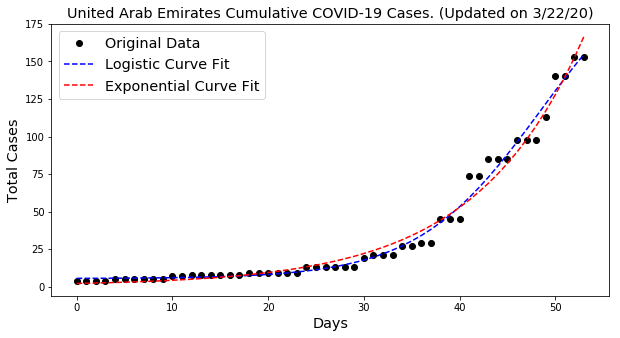



Latvia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 139
	Confirmed cases on 3/15/20 	 30
	Ratio: 4.63
	Weekly increase: 363.3 %
	Daily increase: 24.5 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.996678225517
	Doubling Time (during middle of growth):  3.57 (± 0.54 ) days

** Based on Exponential Fit **

	R^2: 0.987383579701
	Doubling Time (represents overall growth):  3.54 (± 0.48 ) days


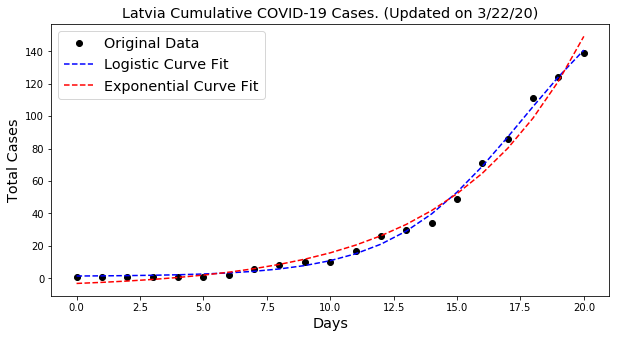



Uruguay

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 135
	Confirmed cases on 3/15/20 	 4
	Ratio: 33.75
	Weekly increase: 3275.0 %
	Daily increase: 65.3 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.99138742832
	Doubling Time (during middle of growth):  2.21 (± 1.12 ) days

** Based on Exponential Fit **

	R^2: 0.980104011021
	Doubling Time (represents overall growth):  6.03 (± 5.42 ) days


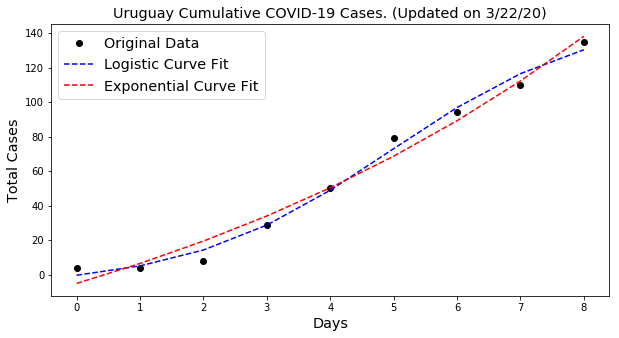



Costa Rica

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 134
	Confirmed cases on 3/15/20 	 27
	Ratio: 4.96
	Weekly increase: 396.3 %
	Daily increase: 25.7 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.991004814904
	Doubling Time (during middle of growth):  6.18 (± 2.93 ) days

** Based on Exponential Fit **

	R^2: 0.99100481524
	Doubling Time (represents overall growth):  3.09 (± 0.42 ) days


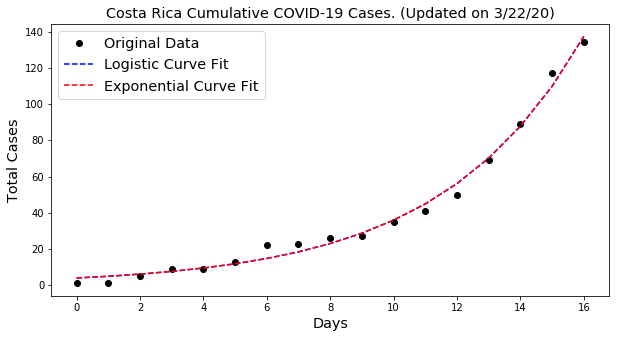



Lithuania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 131
	Confirmed cases on 3/15/20 	 12
	Ratio: 10.92
	Weekly increase: 991.7 %
	Daily increase: 40.7 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.991782585432
	Doubling Time (represents overall growth):  1.67 (± 0.14 ) days


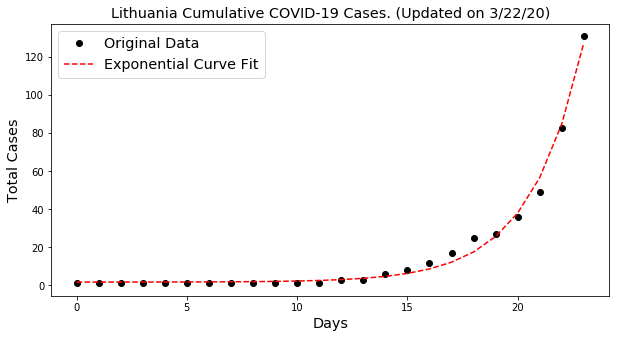



Hungary

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 131
	Confirmed cases on 3/15/20 	 32
	Ratio: 4.09
	Weekly increase: 309.4 %
	Daily increase: 22.3 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.997507543482
	Doubling Time (during middle of growth):  7.33 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.997507543585
	Doubling Time (represents overall growth):  3.67 (± 0.25 ) days


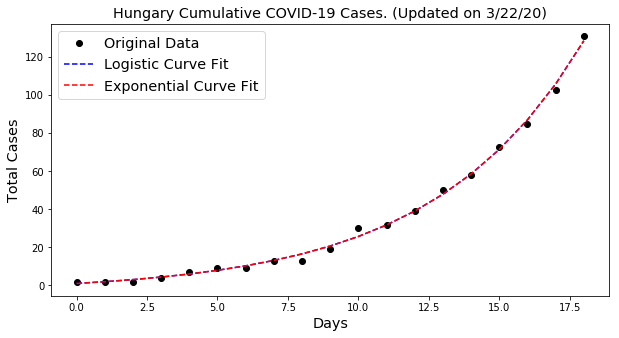



Bosnia and Herzegovina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 126
	Confirmed cases on 3/15/20 	 24
	Ratio: 5.25
	Weekly increase: 425.0 %
	Daily increase: 26.7 % per day
	Doubling Time (represents recent growth): 2.9 days

** Based on Logistic Fit**

	R^2: 0.985159788808
	Doubling Time (during middle of growth):  4.03 (± 1.81 ) days

** Based on Exponential Fit **

	R^2: 0.984066428209
	Doubling Time (represents overall growth):  2.68 (± 0.43 ) days


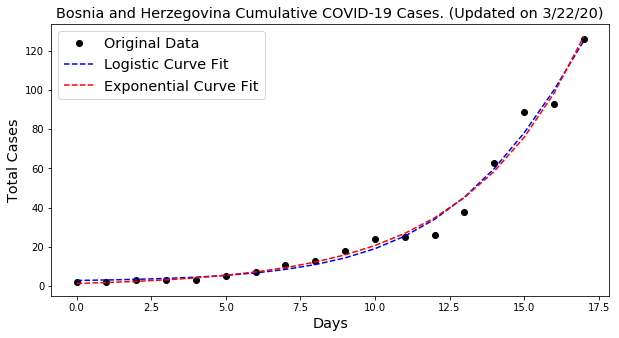



Morocco

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 115
	Confirmed cases on 3/15/20 	 28
	Ratio: 4.11
	Weekly increase: 310.7 %
	Daily increase: 22.4 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Logistic Fit**

	R^2: 0.996478301888
	Doubling Time (during middle of growth):  4.29 (± 0.77 ) days

** Based on Exponential Fit **

	R^2: 0.993286471737
	Doubling Time (represents overall growth):  3.17 (± 0.3 ) days


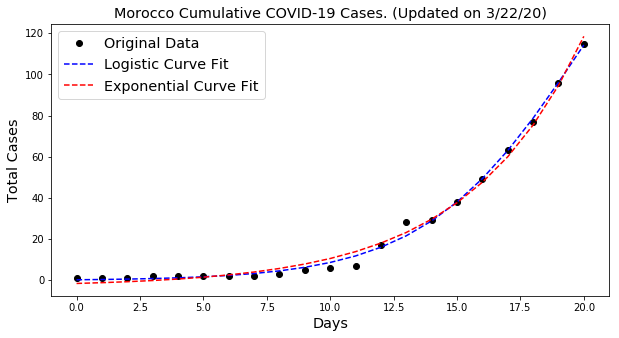



North Macedonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 114
	Confirmed cases on 3/15/20 	 14
	Ratio: 8.14
	Weekly increase: 714.3 %
	Daily increase: 34.9 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Exponential Fit **

	R^2: 0.997184919807
	Doubling Time (represents overall growth):  2.37 (± 0.11 ) days


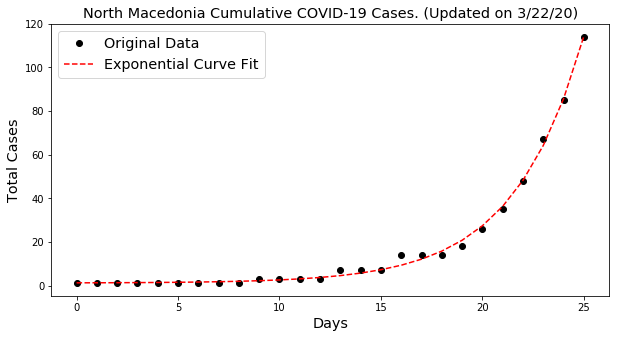



Andorra

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 113
	Confirmed cases on 3/15/20 	 1
	Ratio: 113.0
	Weekly increase: 11200.0 %
	Daily increase: 96.5 % per day
	Doubling Time (represents recent growth): 1.0 days

** Based on Logistic Fit**

	R^2: 0.977895978663
	Doubling Time (during middle of growth):  2.33 (± 0.84 ) days

** Based on Exponential Fit **

	R^2: 0.960714974651
	Doubling Time (represents overall growth):  2.38 (± 0.5 ) days


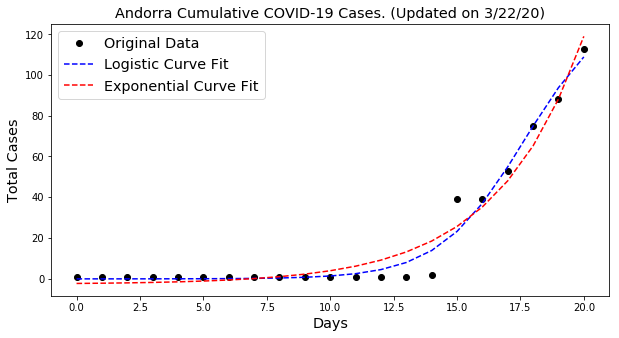



Vietnam

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 113
	Confirmed cases on 3/15/20 	 56
	Ratio: 2.02
	Weekly increase: 101.8 %
	Daily increase: 10.5 % per day
	Doubling Time (represents recent growth): 6.9 days

** Based on Exponential Fit **

	R^2: 0.968601801347
	Doubling Time (represents overall growth):  5.95 (± 0.6 ) days


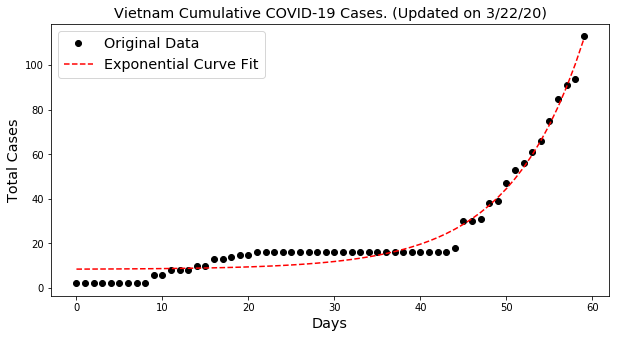



Jordan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 112
	Confirmed cases on 3/15/20 	 8
	Ratio: 14.0
	Weekly increase: 1300.0 %
	Daily increase: 45.8 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.989886280031
	Doubling Time (during middle of growth):  2.0 (± 0.47 ) days

** Based on Exponential Fit **

	R^2: 0.957626104199
	Doubling Time (represents overall growth):  2.92 (± 0.72 ) days


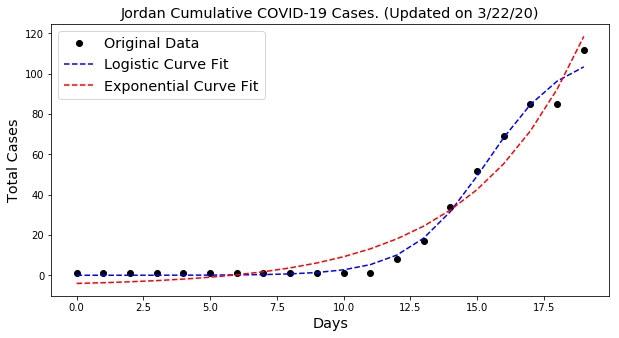

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


                 Countries  Inferred Doubling Time  Recent Doubling Time
0                    China                     6.5                1000.0
1                    Italy                     4.8                   5.6
2                       US                     2.2                   2.2
3                    Spain                     4.9                   3.7
4                  Germany                     3.3                   3.3
5                     Iran                     7.7                  11.0
6                   France                     4.0                   3.8
7             Korea, South                     NaN                  56.3
8              Switzerland                     3.4                   4.1
9           United Kingdom                     3.1            

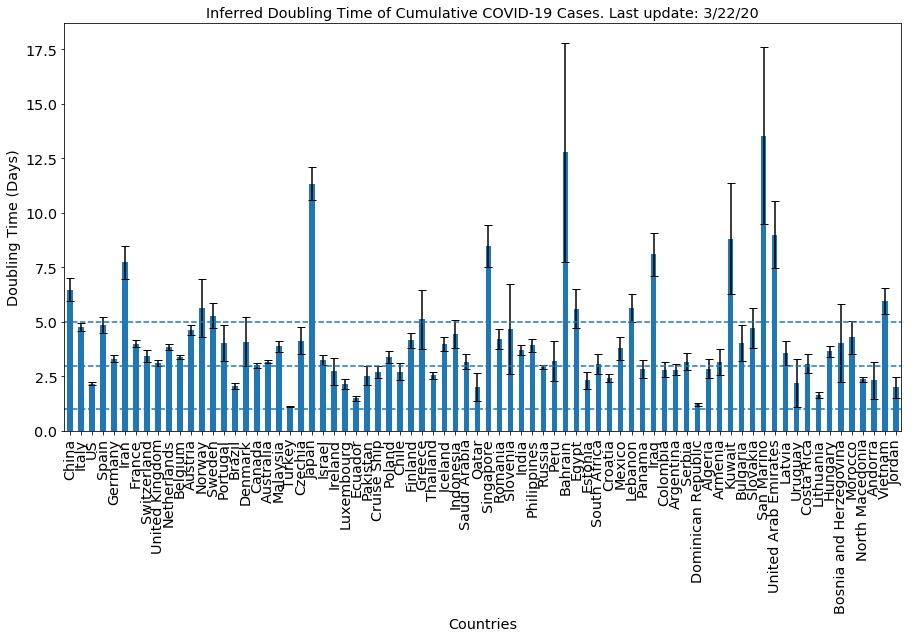

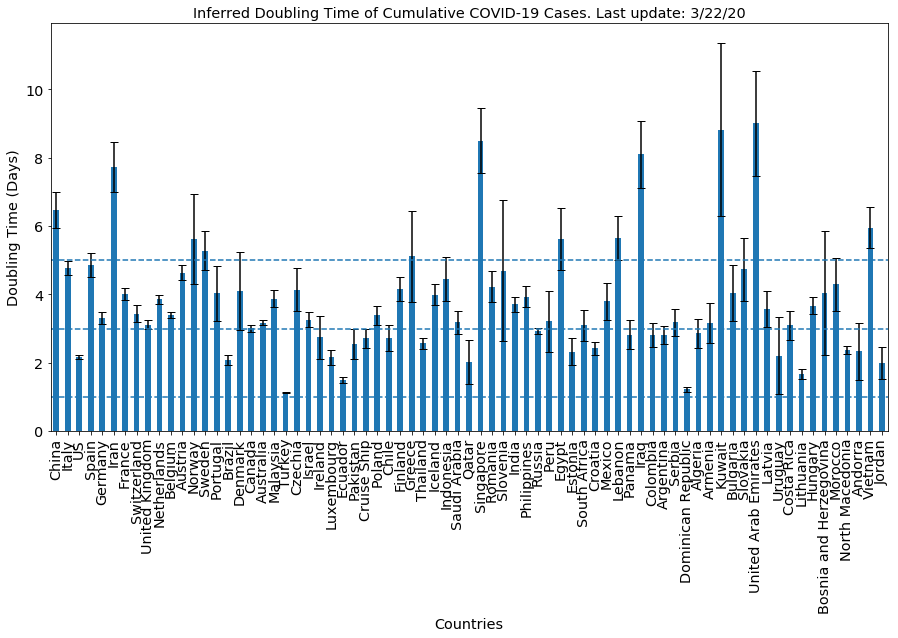

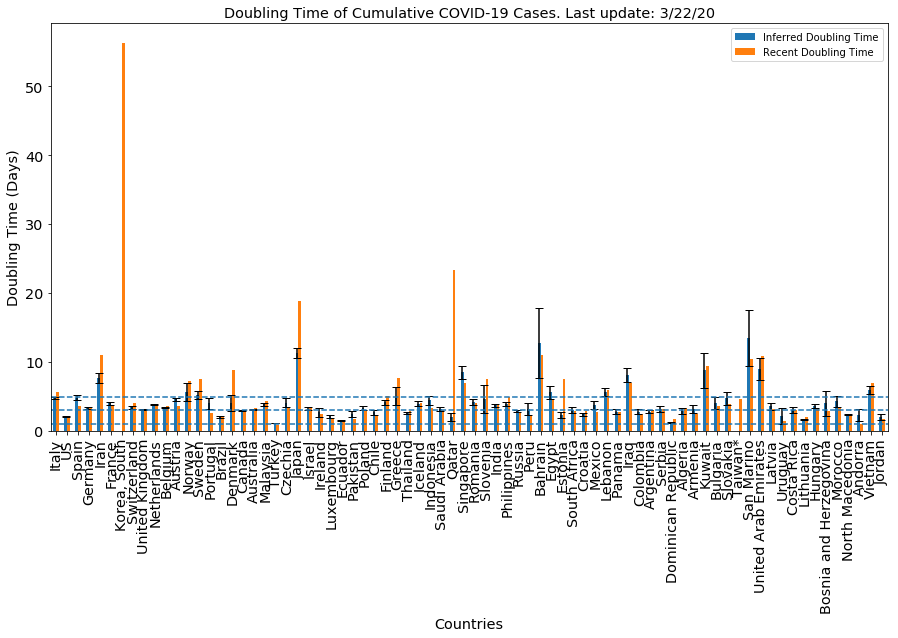

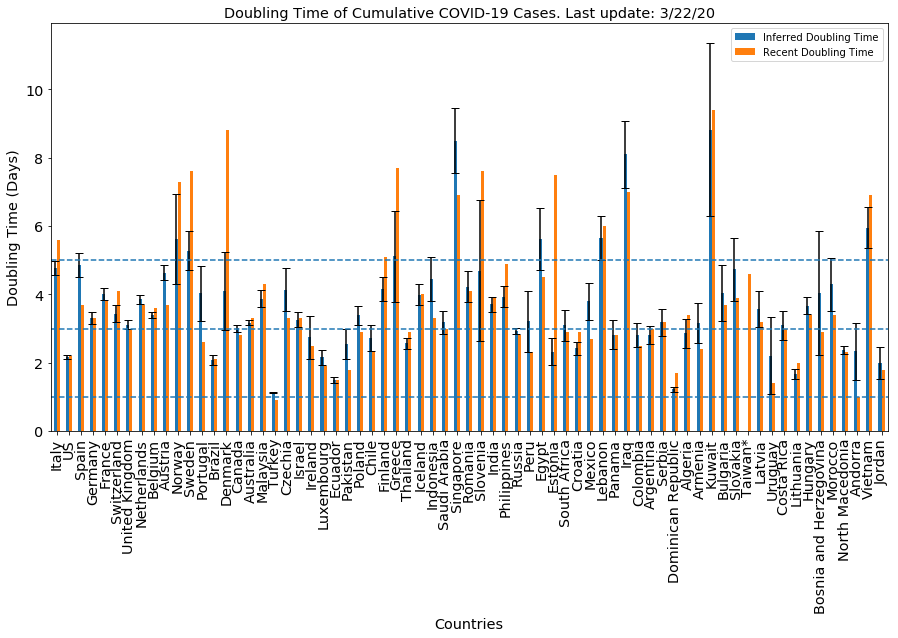

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large", capsize=4);
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err, capsize=4)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/22/20


3/22/20
Province/State               
New York                15793
Washington               1996
New Jersey               1914
California               1642
Illinois                 1049
Michigan                 1037
Louisiana                 837
Florida                   830
Massachusetts             646
Texas                     627
Georgia                   600
Pennsylvania              509
Tennessee                 505
Colorado                  476
Wisconsin                 381
Ohio                      355
North Carolina            302
Maryland                  244
Connecticut               223
Virginia                  221
Mississippi               207
Indiana                   201
South Carolina            196
Nevada                    190
Utah                      181
Minnesota                 169
Arkansas                  165
Oregon                    161
Arizona                   152
Alabama                   138
District of Columbia      102
Missouri                  100
Kentucky                   99
Iowa                       90
Maine                      89
Rhode Island               83
Oklahoma                   67
New Hampshire              65
Kansas                     64
New Mexico                 57
Vermont                    52
Nebraska                   51
Diamond Princess           49
Hawaii                     48
Delaware                   47
Idaho                      42
Montana                    31
Grand Princess             30
North Dakota               28
Guam                       27
Wyoming                    24
Puerto Rico                23
Alaska                     21
South Dakota               21
West Virginia              12
Virgin Islands              3

## Curve Fitting US COVID-19 Cases

                      3/22/20
Province/State               
New York                15793
Washington               1996
New Jersey               1914
California               1642
Illinois                 1049
Michigan                 1037
Louisiana                 837
Florida                   830
Massachusetts             646
Texas                     627
Georgia                   600
Pennsylvania              509
Tennessee                 505
Colorado                  476
Wisconsin                 381
Ohio                      355
North Carolina            302
Maryland                  244
Connecticut               223
Virginia                  221
Mississippi               207
Indiana                   201
South Carolina            196
Nevada                    190
Utah                      181
Minnesota                 169
Arkansas                  165
Oregon                    161
Arizona                   152
Alabama                   138
District of Columbia      102
Missouri  

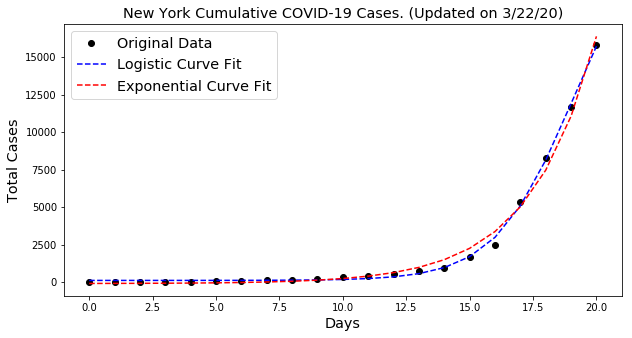



US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1996
	Confirmed cases on 3/15/20 	 643
	Ratio: 3.1
	Weekly increase: 210.4 %
	Daily increase: 17.6 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Exponential Fit **

	R^2: 0.990357467063
	Doubling Time (represents overall growth):  4.32 (± 0.23 ) days


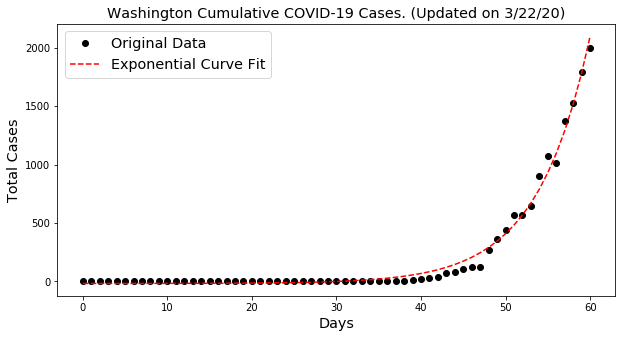



US state:  New Jersey

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1914
	Confirmed cases on 3/15/20 	 98
	Ratio: 19.53
	Weekly increase: 1853.1 %
	Daily increase: 52.9 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.992801741296
	Doubling Time (during middle of growth):  2.94 (± 0.85 ) days

** Based on Exponential Fit **

	R^2: 0.991871309609
	Doubling Time (represents overall growth):  1.81 (± 0.18 ) days


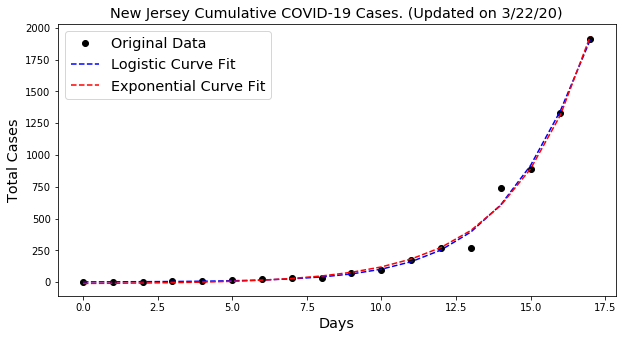



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1642
	Confirmed cases on 3/15/20 	 426
	Ratio: 3.85
	Weekly increase: 285.4 %
	Daily increase: 21.3 % per day
	Doubling Time (represents recent growth): 3.6 days

** Based on Exponential Fit **

	R^2: 0.998032921535
	Doubling Time (represents overall growth):  3.57 (± 0.09 ) days


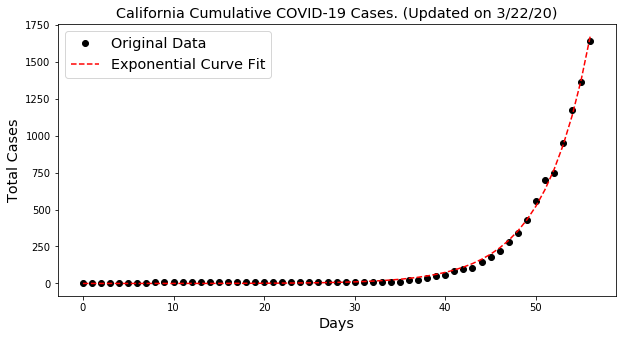



US state:  Illinois

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1049
	Confirmed cases on 3/15/20 	 93
	Ratio: 11.28
	Weekly increase: 1028.0 %
	Daily increase: 41.4 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.991619950378
	Doubling Time (represents overall growth):  1.94 (± 0.1 ) days


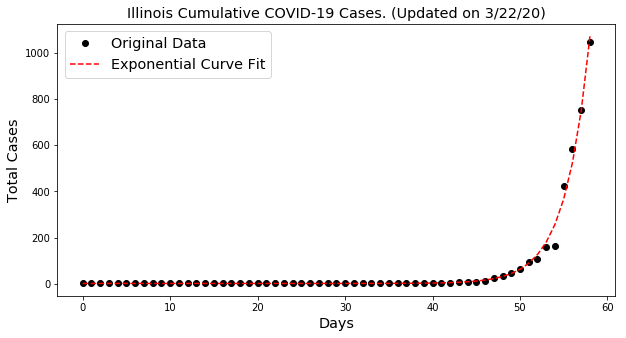



US state:  Michigan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 1037
	Confirmed cases on 3/15/20 	 33
	Ratio: 31.42
	Weekly increase: 3042.4 %
	Daily increase: 63.6 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.995020896364
	Doubling Time (during middle of growth):  1.5 (± 0.37 ) days

** Based on Exponential Fit **

	R^2: 0.977576607943
	Doubling Time (represents overall growth):  1.79 (± 0.45 ) days


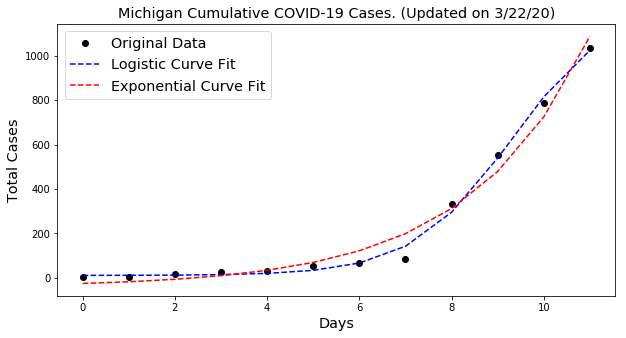



US state:  Louisiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 837
	Confirmed cases on 3/15/20 	 91
	Ratio: 9.2
	Weekly increase: 819.8 %
	Daily increase: 37.3 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.992618763696
	Doubling Time (during middle of growth):  4.29 (± 2.06 ) days

** Based on Exponential Fit **

	R^2: 0.992028347363
	Doubling Time (represents overall growth):  2.77 (± 0.42 ) days


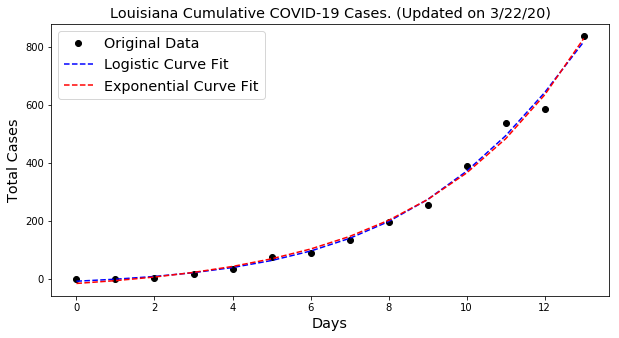



US state:  Florida

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 830
	Confirmed cases on 3/15/20 	 115
	Ratio: 7.22
	Weekly increase: 621.7 %
	Daily increase: 32.6 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.999091668388
	Doubling Time (during middle of growth):  3.44 (± 0.28 ) days

** Based on Exponential Fit **

	R^2: 0.994113936013
	Doubling Time (represents overall growth):  2.74 (± 0.23 ) days


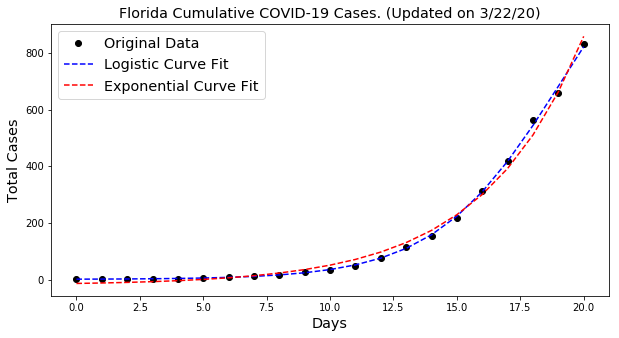



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 646
	Confirmed cases on 3/15/20 	 164
	Ratio: 3.94
	Weekly increase: 293.9 %
	Daily increase: 21.6 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.98907536274
	Doubling Time (represents overall growth):  3.37 (± 0.21 ) days


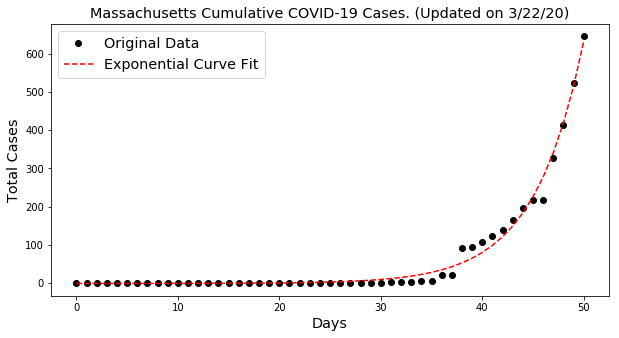



US state:  Texas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 627
	Confirmed cases on 3/15/20 	 72
	Ratio: 8.71
	Weekly increase: 770.8 %
	Daily increase: 36.2 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.991882984161
	Doubling Time (during middle of growth):  2.22 (± 0.55 ) days

** Based on Exponential Fit **

	R^2: 0.981251922597
	Doubling Time (represents overall growth):  2.27 (± 0.37 ) days


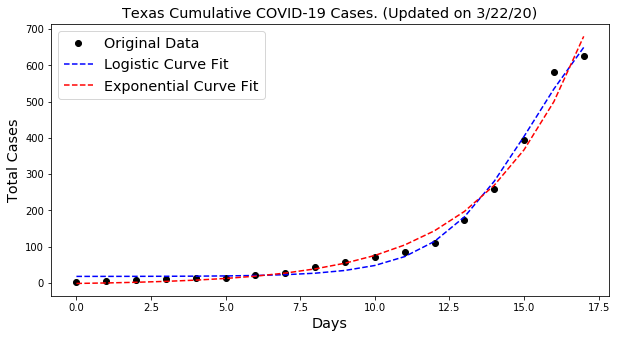



US state:  Georgia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 600
	Confirmed cases on 3/15/20 	 99
	Ratio: 6.06
	Weekly increase: 506.1 %
	Daily increase: 29.4 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Logistic Fit**

	R^2: 0.996384005068
	Doubling Time (during middle of growth):  3.48 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.992359386944
	Doubling Time (represents overall growth):  2.7 (± 0.27 ) days


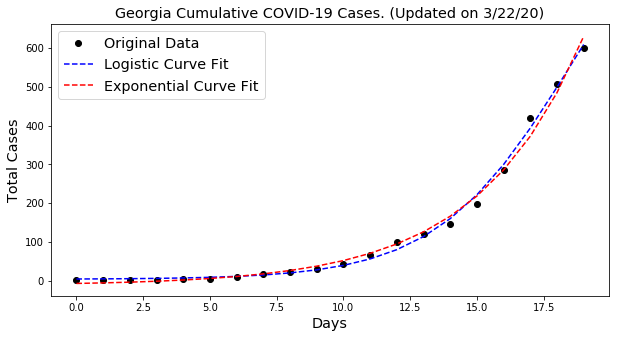



US state:  Pennsylvania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 509
	Confirmed cases on 3/15/20 	 66
	Ratio: 7.71
	Weekly increase: 671.2 %
	Daily increase: 33.9 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.998656599049
	Doubling Time (during middle of growth):  3.9 (± 0.57 ) days

** Based on Exponential Fit **

	R^2: 0.99806656211
	Doubling Time (represents overall growth):  2.37 (± 0.13 ) days


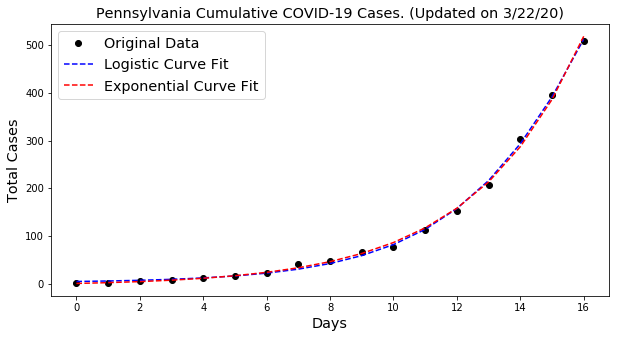



US state:  Tennessee

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 505
	Confirmed cases on 3/15/20 	 39
	Ratio: 12.95
	Weekly increase: 1194.9 %
	Daily increase: 44.2 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.995010370689
	Doubling Time (represents overall growth):  1.73 (± 0.14 ) days


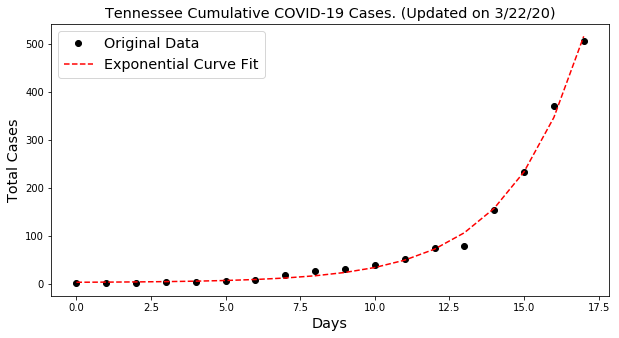



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 476
	Confirmed cases on 3/15/20 	 131
	Ratio: 3.63
	Weekly increase: 263.4 %
	Daily increase: 20.2 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.988345337499
	Doubling Time (during middle of growth):  5.95 (± 3.55 ) days

** Based on Exponential Fit **

	R^2: 0.987779996376
	Doubling Time (represents overall growth):  3.91 (± 0.71 ) days


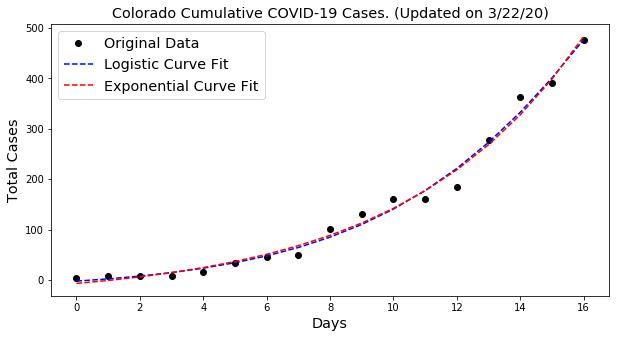



US state:  Wisconsin

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 381
	Confirmed cases on 3/15/20 	 32
	Ratio: 11.91
	Weekly increase: 1090.6 %
	Daily increase: 42.5 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.99819509705
	Doubling Time (during middle of growth):  3.45 (± 0.77 ) days

** Based on Exponential Fit **

	R^2: 0.997420500755
	Doubling Time (represents overall growth):  2.23 (± 0.19 ) days


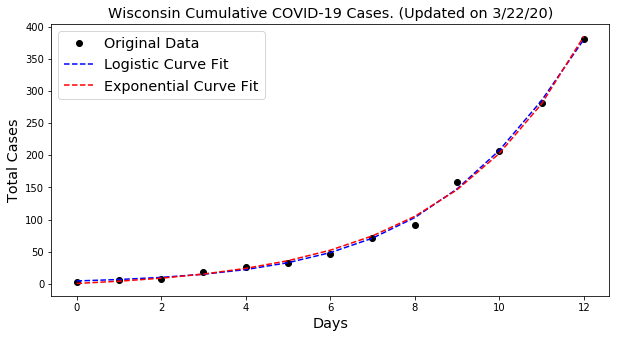



US state:  Ohio

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 355
	Confirmed cases on 3/15/20 	 37
	Ratio: 9.59
	Weekly increase: 859.5 %
	Daily increase: 38.1 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.998403743465
	Doubling Time (during middle of growth):  4.0 (± 0.25 ) days

** Based on Exponential Fit **

	R^2: 0.998403743558
	Doubling Time (represents overall growth):  2.0 (± 0.13 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


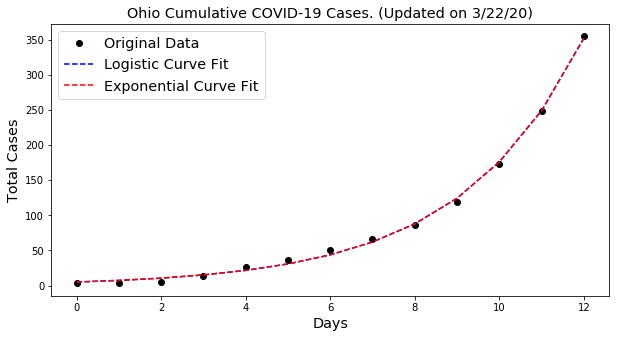



US state:  North Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 302
	Confirmed cases on 3/15/20 	 33
	Ratio: 9.15
	Weekly increase: 815.2 %
	Daily increase: 37.2 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.995098243173
	Doubling Time (during middle of growth):  2.99 (± 0.61 ) days

** Based on Exponential Fit **

	R^2: 0.992088208559
	Doubling Time (represents overall growth):  2.18 (± 0.21 ) days


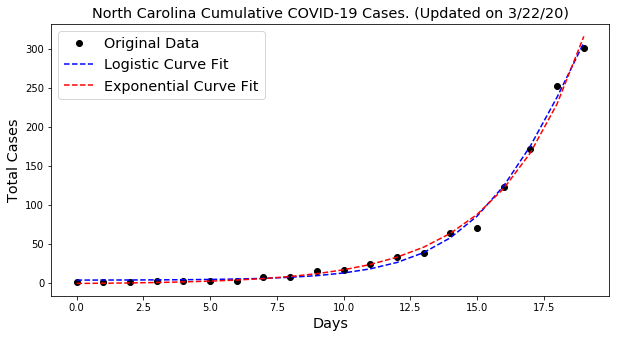



US state:  Maryland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 244
	Confirmed cases on 3/15/20 	 32
	Ratio: 7.62
	Weekly increase: 662.5 %
	Daily increase: 33.7 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.99946799606
	Doubling Time (during middle of growth):  3.9 (± 0.35 ) days

** Based on Exponential Fit **

	R^2: 0.998333649656
	Doubling Time (represents overall growth):  2.54 (± 0.14 ) days


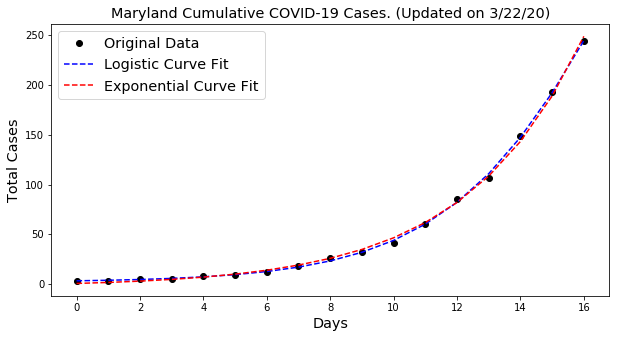



US state:  Connecticut

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 223
	Confirmed cases on 3/15/20 	 24
	Ratio: 9.29
	Weekly increase: 829.2 %
	Daily increase: 37.5 % per day
	Doubling Time (represents recent growth): 2.2 days

** Based on Logistic Fit**

	R^2: 0.980024406045
	Doubling Time (during middle of growth):  1.52 (± 0.65 ) days


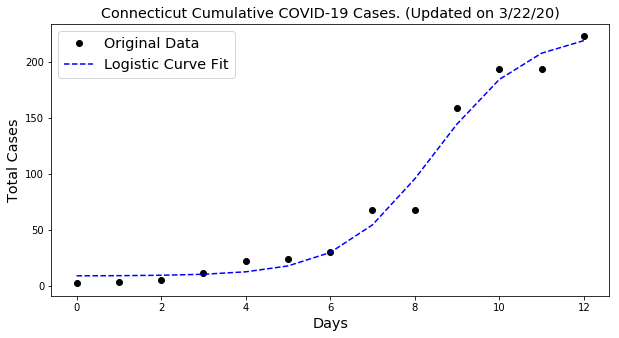



US state:  Virginia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 221
	Confirmed cases on 3/15/20 	 45
	Ratio: 4.91
	Weekly increase: 391.1 %
	Daily increase: 25.5 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.989296179101
	Doubling Time (during middle of growth):  5.8 (± 0.7 ) days

** Based on Exponential Fit **

	R^2: 0.989296180095
	Doubling Time (represents overall growth):  2.9 (± 0.48 ) days


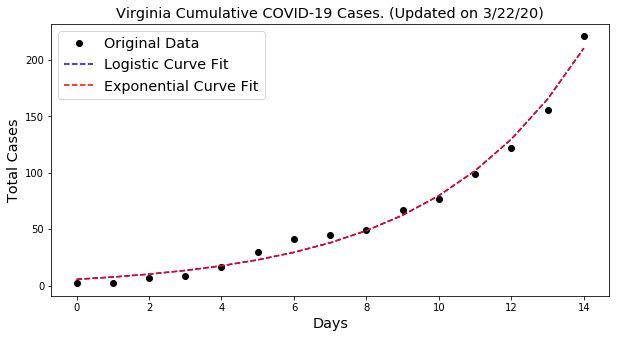



US state:  Mississippi

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 207
	Confirmed cases on 3/15/20 	 10
	Ratio: 20.7
	Weekly increase: 1970.0 %
	Daily increase: 54.2 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.998282574776
	Doubling Time (during middle of growth):  2.57 (± 0.63 ) days

** Based on Exponential Fit **

	R^2: 0.99789774734
	Doubling Time (represents overall growth):  1.53 (± 0.12 ) days


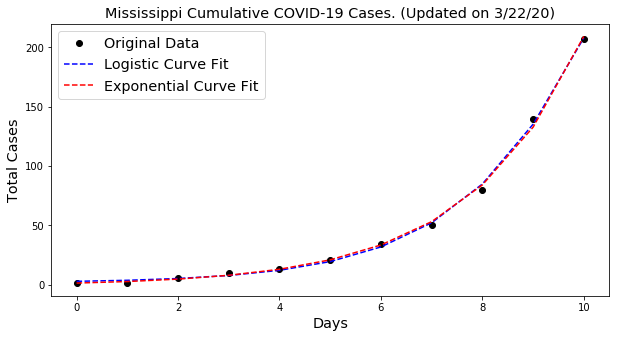



US state:  Indiana

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 201
	Confirmed cases on 3/15/20 	 20
	Ratio: 10.05
	Weekly increase: 905.0 %
	Daily increase: 39.0 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Exponential Fit **

	R^2: 0.995618934176
	Doubling Time (represents overall growth):  1.64 (± 0.13 ) days


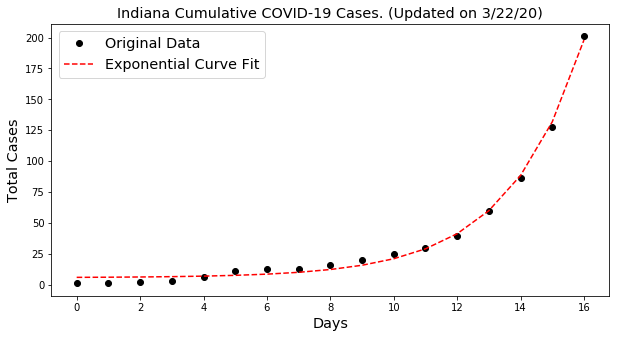



US state:  South Carolina

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 196
	Confirmed cases on 3/15/20 	 28
	Ratio: 7.0
	Weekly increase: 600.0 %
	Daily increase: 32.0 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.989982141973
	Doubling Time (during middle of growth):  2.76 (± 0.92 ) days

** Based on Exponential Fit **

	R^2: 0.985343225597
	Doubling Time (represents overall growth):  2.37 (± 0.39 ) days


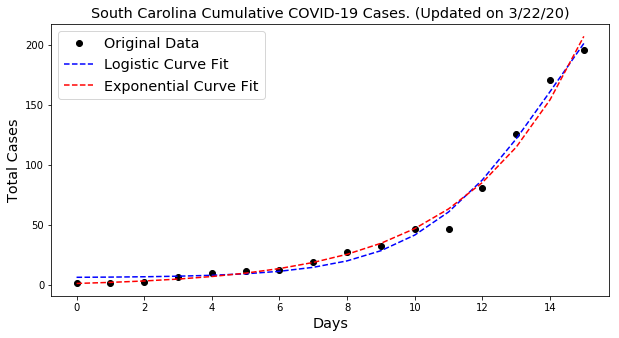



US state:  Nevada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 190
	Confirmed cases on 3/15/20 	 24
	Ratio: 7.92
	Weekly increase: 691.7 %
	Daily increase: 34.4 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.992870623115
	Doubling Time (during middle of growth):  4.28 (± 1.39 ) days

** Based on Exponential Fit **

	R^2: 0.992038307189
	Doubling Time (represents overall growth):  2.69 (± 0.3 ) days


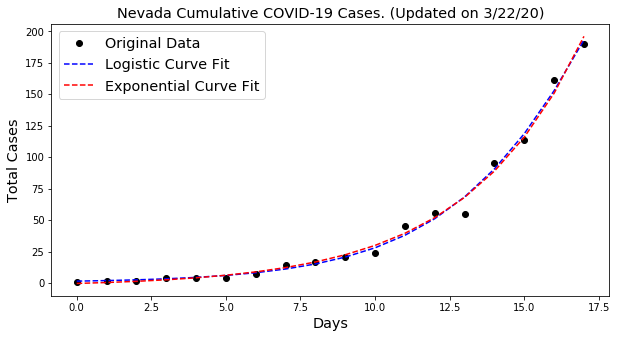



US state:  Utah

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 181
	Confirmed cases on 3/15/20 	 28
	Ratio: 6.46
	Weekly increase: 546.4 %
	Daily increase: 30.6 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.981228795839
	Doubling Time (during middle of growth):  4.87 (± 2.25 ) days

** Based on Exponential Fit **

	R^2: 0.98122879642
	Doubling Time (represents overall growth):  2.44 (± 0.46 ) days


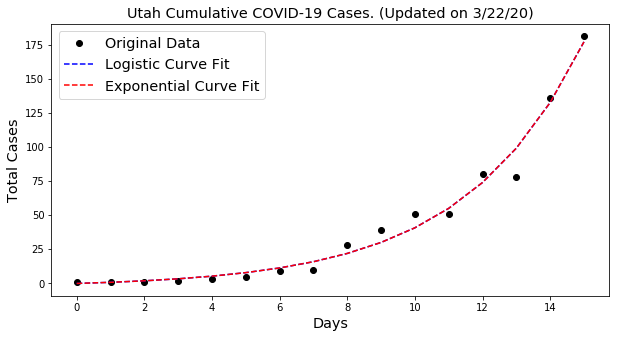



US state:  Minnesota

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 169
	Confirmed cases on 3/15/20 	 35
	Ratio: 4.83
	Weekly increase: 382.9 %
	Daily increase: 25.2 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Logistic Fit**

	R^2: 0.995630957335
	Doubling Time (during middle of growth):  4.97 (± 1.46 ) days

** Based on Exponential Fit **

	R^2: 0.99399460576
	Doubling Time (represents overall growth):  3.66 (± 0.45 ) days


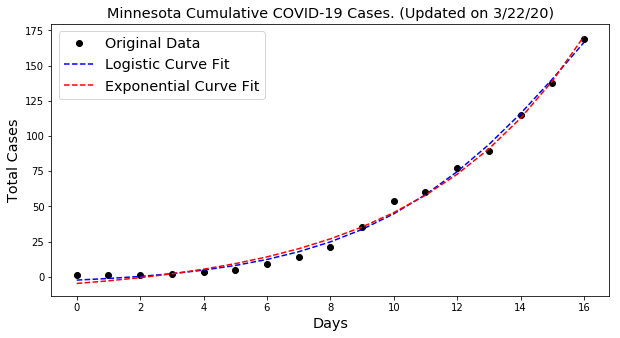



US state:  Arkansas

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 165
	Confirmed cases on 3/15/20 	 16
	Ratio: 10.31
	Weekly increase: 931.2 %
	Daily increase: 39.6 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.994095883164
	Doubling Time (during middle of growth):  2.42 (± 0.81 ) days

** Based on Exponential Fit **

	R^2: 0.990278146667
	Doubling Time (represents overall growth):  2.1 (± 0.37 ) days


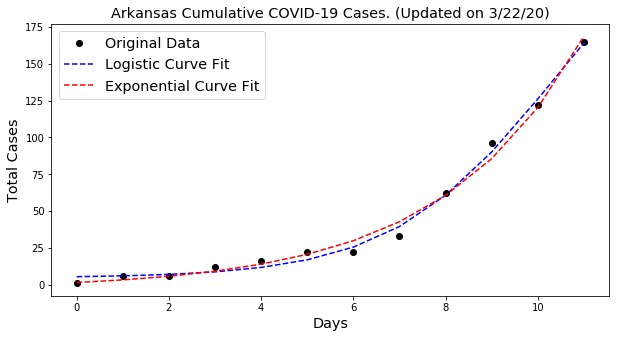



US state:  Oregon

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 161
	Confirmed cases on 3/15/20 	 36
	Ratio: 4.47
	Weekly increase: 347.2 %
	Daily increase: 23.9 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.987765487136
	Doubling Time (during middle of growth):  7.17 (± 1.78 ) days

** Based on Exponential Fit **

	R^2: 0.98776548743
	Doubling Time (represents overall growth):  3.58 (± 0.44 ) days


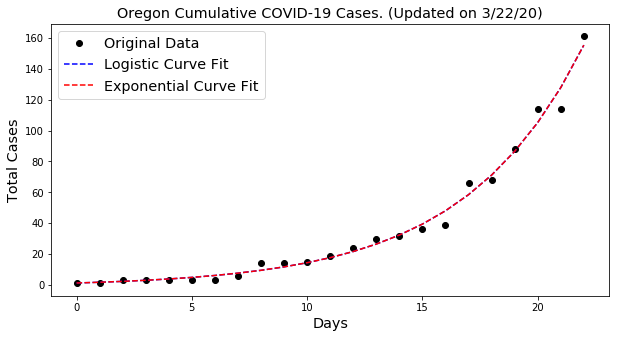



US state:  Arizona

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 152
	Confirmed cases on 3/15/20 	 13
	Ratio: 11.69
	Weekly increase: 1069.2 %
	Daily increase: 42.1 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.991302584909
	Doubling Time (represents overall growth):  1.82 (± 0.09 ) days


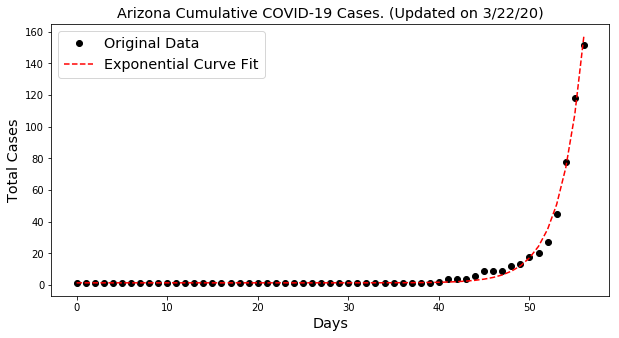



US state:  Alabama

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 138
	Confirmed cases on 3/15/20 	 12
	Ratio: 11.5
	Weekly increase: 1050.0 %
	Daily increase: 41.8 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Logistic Fit**

	R^2: 0.98028252862
	Doubling Time (during middle of growth):  3.25 (± 3.23 ) days

** Based on Exponential Fit **

	R^2: 0.976780851526
	Doubling Time (represents overall growth):  4.0 (± 2.23 ) days


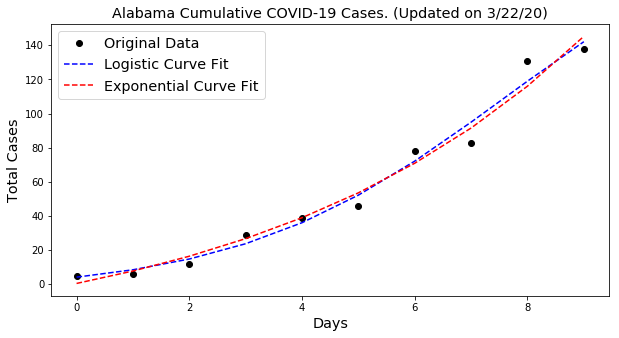



US state:  District of Columbia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 102
	Confirmed cases on 3/15/20 	 16
	Ratio: 6.38
	Weekly increase: 537.5 %
	Daily increase: 30.3 % per day
	Doubling Time (represents recent growth): 2.6 days

** Based on Logistic Fit**

	R^2: 0.983904474945
	Doubling Time (during middle of growth):  3.46 (± 1.84 ) days

** Based on Exponential Fit **

	R^2: 0.982598858546
	Doubling Time (represents overall growth):  2.44 (± 0.48 ) days


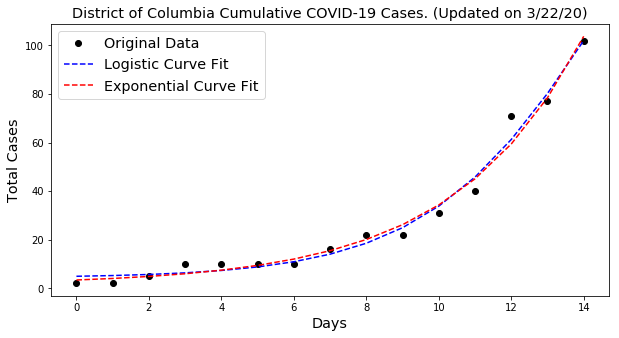



US state:  Missouri

** Based on Most Recent Week of Data **

	Confirmed cases on 3/22/20 	 100
	Confirmed cases on 3/15/20 	 5
	Ratio: 20.0
	Weekly increase: 1900.0 %
	Daily increase: 53.4 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.999233652517
	Doubling Time (during middle of growth):  2.11 (± 0.19 ) days

** Based on Exponential Fit **

	R^2: 0.992594153732
	Doubling Time (represents overall growth):  1.81 (± 0.21 ) days


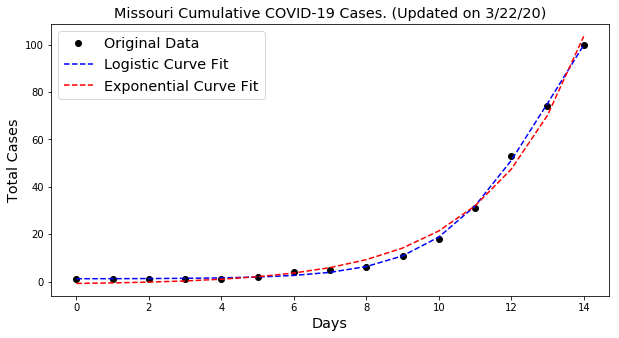

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


                  States  Inferred Doubling Time  Recent Doubling Time
0               New York                     2.1                   1.6
1             Washington                     4.3                   4.3
2             New Jersey                     1.8                   1.6
3             California                     3.6                   3.6
4               Illinois                     1.9                   2.0
5               Michigan                     1.5                   1.4
6              Louisiana                     2.8                   2.2
7                Florida                     3.4                   2.5
8          Massachusetts                     3.4                   3.5
9                  Texas                     2.2                   2.2
10         

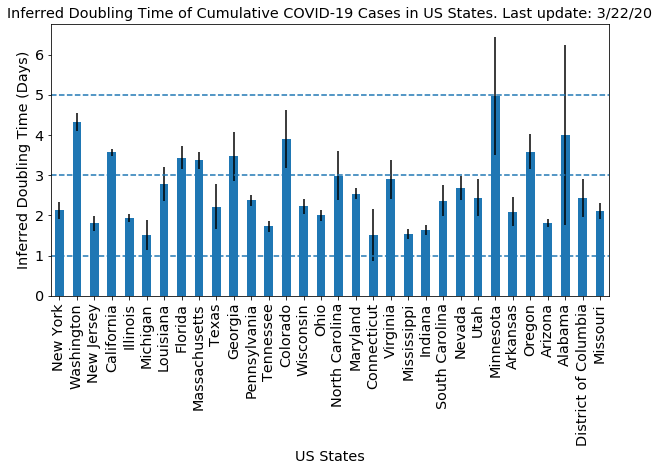

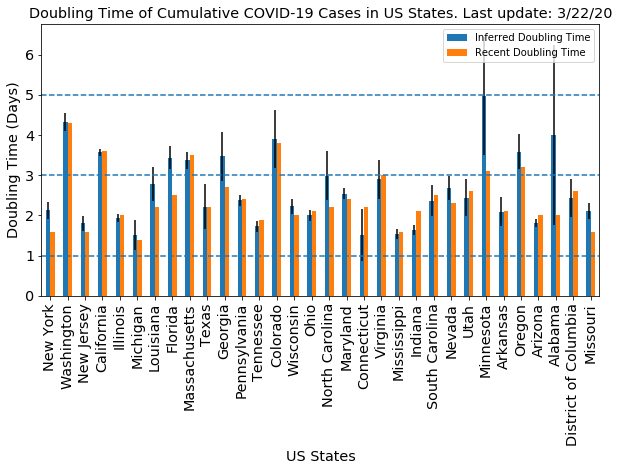

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()